# PREPROCESSING

In [3]:
import os
import librosa
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import nltk
import parselmouth 
from parselmouth.praat import call
import cmudict
import regex as re
import ffmpeg
import math
import dtale
import shutil
from scipy.special import eval_legendre
import scipy.stats
import statistics
import tgt
nltk.download('cmudict')
plus = pd.read_csv('mustard++_text.csv')

[nltk_data] Downloading package cmudict to
[nltk_data]     C:\Users\kasia\AppData\Roaming\nltk_data...
[nltk_data]   Package cmudict is already up-to-date!


In [468]:
# remove useless stuff
plus = plus[plus['Sarcasm'].notna()] #keeps utterances
pd.set_option('display.max_colwidth', None)
plus.loc[plus['SENTENCE'].str.contains('?', regex=False), 'QUESTION?'] = True #is this utterance a Q?
plus['QUESTION?'] = plus['QUESTION?'].fillna(False)
plus = plus.infer_objects(copy=False)
plus['Sarcasm'] = plus['Sarcasm'].astype(bool)
drop = ['1_1001', '1_S09E02_424', '1_S11E11_077','2_13','2_163','2_198', '1_8837']  
plus = plus[~plus['SCENE'].isin(drop)]
plus = plus[plus['SCENE'] != '1_1001']
plus['SCENE'] = plus['SCENE'].astype(str) + '_u' 
plus = plus.drop(columns=['KEY','Sarcasm_Type', 'END_TIME','Implicit_Emotion','Explicit_Emotion','Valence','Arousal', 'SENTENCE'])
spee = ['RAJ', 'DINESH', 'MODERATOR', 'MEMBER-GIRL','MEMBER-BOY'] #removes non american accents
plus = plus[~plus['SPEAKER'].isin(spee)]
plus.loc[plus['SCENE'] == '2_55_u', ['SPEAKER']] = 'SHELDON'
plus = plus.reset_index()

C:\Users\kasia\AppData\Local\Temp\ipykernel_25764\3652957297.py:5: FutureWarning:

Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



In [469]:
plus = plus.drop(columns=['index'])

In [470]:
# add gender label
man = [
    '1_4639_u','1_4789_u','1_7494_u','1_7504_u',
    '1_7953_u','1_8136_u','1_9963_u','1_11051_u',
    '1_11885_u','2_55_u','2_150_u','2_193_u','2_228_u',
    '2_245_u','2_278_u','2_295_u','2_341_u','2_415_u',
    '2_530_u','2_548_u','2_609_u','2_627_u','1_6645_u',
    '2_42_u','1_S10E01_225_u','1_S11E08_351_u','1_S12E02_274_u',
    '1_S12E04_204_u','1_S12E04_233_u','1_S12E11_072_u','1_S12E20_378_u',
    '3_S01E02_461_u','3_S01E04_327_u'
]
men = [
    'SHELDON','HOWARD','LEONARD','STUART',
    'CHANDLER','JOEY','ROSS','GILFOYLE',
    'RICHARD','ERLICH'
]
meeen = plus["SCENE"].isin(man) | plus["SPEAKER"].isin(men)
print(meeen.value_counts())
plus["GENDER"] = meeen.map({True: "M", False: "F"})

True     699
False    420
Name: count, dtype: int64


In [471]:
# how long is this? expected: 102
print(len(plus))

1119


In [472]:
what = plus[plus['SCENE'].str.contains("1_S12E23_539")]
what

,SCENE,SPEAKER,SHOW,Sarcasm,QUESTION?,GENDER
655,1_S12E23_539_u,HOWARD,BBT,True,True,M


In [473]:
#removes rows w/o audio
root_folder = r"C:\Users\kasia\asp2025\textgrids"
wav_files = []
for dirpath, _, filenames in os.walk(root_folder):
    for f in filenames:
        if f.lower().endswith(".wav"):
            wav_files.append(f)

wav_set = set(wav_files)
wav_set = {os.path.splitext(f)[0] for f in wav_set}
plus = plus[plus["SCENE"].str.strip().isin(wav_set)]
plus = plus.reset_index()

In [474]:
dtale.show(plus)

In [475]:
# how many utterances? expected:872
print(len(plus)) 

872


### ADD SARCASM TYPE

In [476]:
#adds sarcasm type labels
all_1 = []
df = pd.read_csv('data_w_typeV2.csv')
ones = df[df['TYPE'] == 1]

for idx, key in ones['SCENE'].items():
    scene = df.loc[idx, 'SCENE']
    all_1.append(scene)
    #print(scene)
#print(all_1)

for idx, key in plus['SCENE'].items():
    scene_true = plus.loc[idx, 'SCENE']
    if scene_true in all_1:
        plus.loc[idx, 'TYPE'] = 1

##############################################################################
all_2 = []
df = pd.read_csv('data_w_type.csv')
twos = df[df['TYPE'] == 2]

for idx, key in twos['SCENE'].items():
    scene = df.loc[idx, 'SCENE']
    all_2.append(scene)
    #print(scene)
#print(all_1)

for idx, key in plus['SCENE'].items():
    scene_true = plus.loc[idx, 'SCENE']
    if scene_true in all_2:
        plus.loc[idx, 'TYPE'] = 2
#############################################################################
all_3 = []
df = pd.read_csv('data_w_type.csv')
threes = df[df['TYPE'] == 3]

for idx, key in threes['SCENE'].items():
    scene = df.loc[idx, 'SCENE']
    all_3.append(scene)
    #print(scene)
#print(all_1)

for idx, key in plus['SCENE'].items():
    scene_true = plus.loc[idx, 'SCENE']
    if scene_true in all_3:
        plus.loc[idx, 'TYPE'] = 3

plus['TYPE'] = plus['TYPE'].fillna(0)
plus.head()      

,index,SCENE,SPEAKER,SHOW,Sarcasm,QUESTION?,GENDER,TYPE
0,0,1_10004_u,SHELDON,BBT,False,True,M,0.0
1,1,1_10009_u,PENNY,BBT,False,True,F,0.0
2,5,1_10495_u,AMY,BBT,True,False,F,1.0
3,7,1_105_u,SHELDON,BBT,True,False,M,3.0
4,8,1_10748_u,AMY,BBT,True,False,F,1.0


### FIND TRANSCRIPT, WORD COUNT, AND REMOVE UTTERANCES WITH >20 WORDS

In [477]:
def get_times_from_textgrid(path_to_textgrid, tier_name):
    """
    Extract bounadary times for each interval and its annotation
    :param path_to_textgrid: full path to the textgrid file
    :param tier_name: the tier you want to extract annotations from
    :return: List of lists: each list if os the form [annotation, start_time, end_time] for each interval in the textgrid
    """
    textgrid = tgt.io.read_textgrid(path_to_textgrid)
    tier = textgrid.get_tier_by_name(tier_name)
    intervals = []
    for interval in tier:
        curr_interval = []
        curr_interval.append(interval.text)
        curr_interval.append(interval.start_time)
        curr_interval.append(interval.end_time)
        intervals.append(curr_interval)
    return intervals

In [478]:
#get transcript
base_dir = r'C:\Users\kasia\asp2025\textgrids'
plus['TRANSCRIPT'] = None
#this finds the time range for only prom words
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words") #list of lists

        all_words = []
        num_words = len(word_intervals) - 1
        n = 0
        while n <= num_words:
            word = word_intervals[n][0]
            all_words.append(word)
            n += 1
        #print(all_words)
        transcript = ' '.join(all_words)
        #print(transcript)
        plus.loc[idx, 'TRANSCRIPT'] = transcript
            
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")

2026-01-25 20:36:49,868 - ERROR    - Exception occurred while processing request: 'NoneType' object is not iterable
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 2957, in get_data
    curr_dtypes = [c["name"] for c in global_state.get_dtypes(data_id)]
                                      ~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^
TypeError: 'NoneType' object is not iterable
2026-01-25 20:36:50,207 - ERROR    - Exception occurred while processing request: 'NoneType' object is not iterable
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\

In [479]:
#expect: 872
print(len(plus)) 

872


In [480]:
plus["wrd_count"] = plus["TRANSCRIPT"].str.split().str.len()
#plus = plus[plus['wrd_count'] <= 20] #max word count 

In [481]:
#expect: 872
print(len(plus)) 

872


In [482]:
dtale.show(plus)

### CONFIRM NUM FILES

In [483]:
#count num files in folder expected: 2634
file_count = sum(len(files) for _, _, files in os.walk(r'C:\Users\kasia\asp2025\textgrids'))
print(file_count)


2634


In [484]:
#expect: 872
print(len(plus)) 

872


# GLOBAL FEATURES

## PITCH AND INTENSITY FEATURES

In [485]:
base_dir = r'C:\Users\kasia\asp2025\textgrids'

In [486]:
plus['mean_F0'] = None
plus['range_F0'] = None
plus['sd_F0'] = None
plus['mean_db_z'] = None
plus['range_db_z'] = None
plus['sd_db_z'] = None
plus['duration']= None

In [487]:
#expect: 872
print(len(plus)) 

872


In [488]:
def findDuration(sound):
    duration = call(sound, "Get total duration")
    return duration

In [489]:
# Get intensity and pitch contours
def get_contours(sound, start_time, end_time, keep_zeros):
    """
    Extract F0 and intensity contours from wav file, within a given time frame
    :param wav_path: Full path to a single wav file
    :param keep_zeros: True if you want to keep zeros of F0 contour (i.e., keep spaces without an F0 measurement)
    :return: the F0 and intensity contours as lists
    """
    sound_interval = sound.extract_part(from_time=start_time, to_time=end_time)
    try: # This deals with if the extracted part is shorter than the window length
        pitch_contour = sound_interval.to_pitch().interpolate().selected_array['frequency']
        #pitch_contour = sound_interval.to_pitch().selected_array['frequency']
        intensity_contour = sound_interval.to_intensity().values[0]
    except parselmouth.PraatError:
        intensity_contour = [np.nan, np.nan] # this is of length 2 just to avoid errors from statistics functions
        pitch_contour = [np.nan, np.nan]
    if not keep_zeros:
        pitch_contour = [i for i in pitch_contour if i !=0]

    if len(pitch_contour) < 2:
        pitch_contour = [np.nan, np.nan]
    if len(intensity_contour) <2:
        intensity_contour = [np.nan, np.nan]

    return pitch_contour, intensity_contour

# Convert hz to semitones
def f2st(f0_contour,reference_f0):
    """
    Convert Hz to Semitones. Used for Speaker Normalization
    :param f0_contour: list of F0 values
    :param reference_f0: In the case of speaker normalization, this is the mean F0 of the speaker
    :return: List of F0 values in semitones
    """
    return [12*math.log(i/reference_f0,2) for i in f0_contour]

# Convert db to z-scores
def norm_intensity(intensity_contour):
    """
    Conver dB to z-scores. Used for speaker normalization
    :param intensity_contour: Intensity values in dB
    :return: intensity contours in z-scores
    """
    return scipy.stats.zscore(intensity_contour)

def get_mean(contour):
    return statistics.mean(contour)

def get_range(contour):
    return max(contour) - min(contour)

def get_sd(contour):
    return statistics.stdev(contour)



In [490]:
plus['mean_db'] = None
plus['sd_db'] = None
plus['intensity_contour'] = None
plus['intensity_contour'] = plus['intensity_contour'].astype(object)
for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")

        sound = parselmouth.Sound(wav_path)
        
        duration = findDuration(sound)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        mean_F0 = get_mean(pitch_contour)
        range_F0 = get_range(pitch_contour)
        sd_F0 = get_sd(pitch_contour)
        ###################################
        mean_db = get_mean(intensity_contour)
        sd_db = get_sd(intensity_contour)
        db_z = norm_intensity(intensity_contour)
        mean_db_z = get_mean(db_z)
        range_db_z = get_range(db_z)
        sd_db_z = get_sd(db_z)
        
        plus.loc[idx, ['mean_F0', 'sd_F0', 'range_F0', 'duration', 'mean_db_z','range_db_z','sd_db_z', 'mean_db', 'sd_db']] = [
            mean_F0, sd_F0, range_F0, duration, mean_db_z,range_db_z,sd_db_z, mean_db, sd_db
        ]
        plus.at[idx, 'intensity_contour'] = intensity_contour
        
        

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

2026-01-25 20:37:29,280 - ERROR    - Exception occurred while processing request: object of type 'NoneType' has no len()
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1603, in get_processes
    [_load_process(data_id) for data_id in global_state.keys()],
     ~~~~~~~~~~~~~^^^^^^^^^
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1588, in _load_process
    rows=len(data),
         ~~~^^^^^^
TypeError: object of type 'NoneType' has no len()


In [491]:
#finds mean intensity for each speaker
speakeravg = plus.groupby("SPEAKER")["mean_F0"].mean().to_dict()
print(speakeravg)

{'AMY': 224.79080189574753, 'BERNADETTE': 286.70467682020126, 'CHANDLER': 191.4009419872752, 'DOROTHY': 169.95584384044804, 'GILFOYLE': 105.25219091163383, 'HOWARD': 155.30856376022612, 'JOEY': 177.47938222549377, 'LEONARD': 162.5903293978065, 'MONICA': 303.67553434505413, 'PENNY': 252.6706430139552, 'PHOEBE': 307.4698790193512, 'RACHEL': 296.6868774709166, 'ROSS': 201.10299749597866, 'SHELDON': 174.82888884967178}


In [492]:
plus["speaker_mean_f0"] = None
for idx, key in plus['SCENE'].items():
    speaker = plus.loc[idx, "SPEAKER"]
    #g = np.where(speaker_listUnique == speaker)[0]
    mean = speakeravg[speaker]
    plus.loc[idx, "speaker_mean_f0"] = mean

In [493]:
plus["st_mean"]=None
plus["st_sd"] = None
plus["st_range"] = None
for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")
        
        sound = parselmouth.Sound(wav_path)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        speaker_mean = plus.loc[idx, "speaker_mean_f0"]
        st_contour = f2st(pitch_contour, speaker_mean)
        #print(idx, st_contour)

        mean_st = get_mean(st_contour)
        range_st = get_range(st_contour)
        sd_st = get_sd(st_contour)
        plus.loc[idx, ["st_mean","st_sd","st_range"]] = [mean_st, sd_st, range_st]
        

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [494]:
speaker_contours = {} #ANDI, don't print this out! It will crash Jupyter notebook!!!! >:(
speaker_contours_means_inten = {}
speaker_contours_sds_inten = {}
for idx, row in plus.iterrows():
    speaker = row["SPEAKER"]
    contour = row["intensity_contour"]  

    if speaker not in speaker_contours:
        speaker_contours[speaker] = []

    speaker_contours[speaker].extend(contour)

for speaker in speaker_contours:
    ind_contour = speaker_contours[speaker]
    mean = sum(ind_contour)/len(ind_contour)
    sd = np.std(ind_contour, ddof=0) # 0 bc this is the population mean 
    speaker_contours_means_inten[speaker] = mean
    speaker_contours_sds_inten[speaker] = sd


In [495]:
print(speaker_contours_means_inten)

{'SHELDON': np.float64(66.08596104848779), 'PENNY': np.float64(61.01437839107055), 'AMY': np.float64(59.994150307421634), 'HOWARD': np.float64(60.309027477337494), 'BERNADETTE': np.float64(58.25437145334782), 'LEONARD': np.float64(61.741101159326995), 'CHANDLER': np.float64(62.745867011299204), 'DOROTHY': np.float64(80.30339754053833), 'JOEY': np.float64(59.43885235257127), 'RACHEL': np.float64(59.319568078341455), 'ROSS': np.float64(58.54114497589302), 'PHOEBE': np.float64(59.47445572668255), 'MONICA': np.float64(58.55259316341727), 'GILFOYLE': np.float64(63.48519826492458)}


In [496]:
plus['mean_db_fix'] = None
plus['sd_db_fix'] = None
plus['range_db_fix'] = None

for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")

        sound = parselmouth.Sound(wav_path)
        
        duration = findDuration(sound)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        speaker = plus.loc[idx, 'SPEAKER']
        db_z_fix = (intensity_contour - speaker_contours_means_inten[speaker])/speaker_contours_sds_inten[speaker]
        mean_db_fix = get_mean(db_z_fix)
        range_db_fix = get_range(db_z_fix)
        sd_db_fix = get_sd(db_z_fix)
        
        plus.loc[idx, ['mean_db_fix','range_db_fix', 'sd_db_fix']] = [mean_db_fix, range_db_fix, sd_db_fix]  

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [497]:
plus = plus.drop('intensity_contour', axis=1)

In [498]:
#expect: 872
print(len(plus)) 

872


## SPEECH RATE

In [499]:
# vowels: 
#1 = primary
#2 = secondary
#3 = no stress
plus['cmudict'] = None
plus['syl_count'] = None
d = cmudict.dict()

def cmudict_out(text):
    words = re.sub(r"\b(\w+)'[\w]+\b", r"\1", text.lower())
    words = re.findall(r"\b\w+\b", words)
    
    return [(word, d[word][0]) for word in words if word in d]


plus['cmudict'] = plus['TRANSCRIPT'].astype(str).apply(cmudict_out)
plus['syl_count'] = plus['cmudict'].astype(str).apply(lambda x: len(re.findall(r'\d+', x)))
#plus = plus.drop(columns=['cmudict'])
plus['slypersec'] = None
plus['slypersec'] = plus['syl_count']/plus['duration']
plus = plus.drop(columns=['cmudict'])
dtale.show(plus)

In [500]:
speaker_meanspeechrate = plus.groupby("SPEAKER")["slypersec"].mean().to_dict()
print(speaker_meanspeechrate)

{'AMY': 5.2337268938067405, 'BERNADETTE': 4.923037996287565, 'CHANDLER': 4.859418179747528, 'DOROTHY': 4.072422154506618, 'GILFOYLE': 4.987589747381371, 'HOWARD': 4.872607721606251, 'JOEY': 4.20745144668958, 'LEONARD': 5.074342008098685, 'MONICA': 4.914897998433404, 'PENNY': 5.189271728602449, 'PHOEBE': 4.457394059596489, 'RACHEL': 4.558430036197937, 'ROSS': 4.462241614891628, 'SHELDON': 5.023658632499979}


In [501]:
speaker_sdspeechrate = plus.groupby("SPEAKER")["slypersec"].std().to_dict()
print(speaker_sdspeechrate)

{'AMY': 1.4345071690986677, 'BERNADETTE': 1.2218360409615798, 'CHANDLER': 1.3563880726399393, 'DOROTHY': 0.8247510092217228, 'GILFOYLE': 1.0332468779958275, 'HOWARD': 1.2171968513472586, 'JOEY': 1.422810155529511, 'LEONARD': 1.276292219763137, 'MONICA': 2.1067689383520607, 'PENNY': 1.4220561597326833, 'PHOEBE': 1.4313507512315582, 'RACHEL': 1.8573575434927285, 'ROSS': 1.693260499365582, 'SHELDON': 1.2301026021056325}


In [502]:
for idx, key in plus['SCENE'].items():
    try:
        speaker = plus.loc[idx, 'SPEAKER']
        unnorm_speechrate = plus.loc[idx, 'slypersec']
        norm_speechrate = (unnorm_speechrate - speaker_meanspeechrate[speaker])/speaker_sdspeechrate[speaker]
        plus.loc[idx, 'slypersec'] = norm_speechrate
        
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")
        

# WORD LEVEL FEATURES

In [503]:
# Use Legendre polynomials to model pitch and intensity
def get_legendres(contour, n=3): # This operates at word-level. Get a legendre for each word
    """
    Perform Legendre poplynomial expansion on a contour of any acoustic measure
    :param contour: A list of values representing the contour (e.g., pitch or intensity) you want Legendre coefficients for
    :param n: order of legendre polynomials you want coefficients for
    :return: List of n legendre coefficients (i.e. list[0] = 0th legendre coefficient)
    """
    all_legendres = []

    num_xs_contour = len(contour)
    x_vals_contour = np.linspace(-1, 1, num_xs_contour)
    contour_sampled_legendres = [eval_legendre(i, x_vals_contour) for i in range(n)]
    fitted_contours = [2*np.dot(contour, contour_sampled_legendres[i])/num_xs_contour for i in range(len(contour_sampled_legendres))]
    all_legendres += fitted_contours
    return all_legendres

# Helper function to find specific file in a given diretory
def find_file(filename, search_path):
   for root, dir, files in os.walk(search_path):
       if filename in files:
          result=os.path.join(root, filename)
          return result

## SPEECH RATE OF PROMINENT WORD

In [504]:
#this finds the time range for only prom words
plus['cmudict'] = None
plus['prom_syl_count'] = None
plus["prom_duration"] = None
plus['prom_word'] = None
plus['prom_slypersec'] = None
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words")
        prom_intervals = get_times_from_textgrid(path, "p")
        prom_timepoint = prom_intervals[0][1]
        #print(path)
        #print(prom_intervals)
        #print(prom_timepoint)
        #print(word_intervals)
        
        for word in word_intervals:
            start = word[1]
            end = word[2]
            if start < prom_timepoint < end:
                prom_start = start
                prom_end = end
                prom_word = word[0]
                
                break
        prom_duration = prom_end-prom_start
        plus.loc[idx, ["prom_duration", 'prom_word']] = [prom_duration, prom_word]
        #plus = plus.drop(columns=['cmudict'])
        """
        print(path)
        print(f"start time {prom_start}")
        print(f"end time {prom_end}")
        print(f"prom word {prom_word}")
        """
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")

2026-01-25 20:39:47,161 - ERROR    - Exception occurred while processing request: object of type 'NoneType' has no len()
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1603, in get_processes
    [_load_process(data_id) for data_id in global_state.keys()],
     ~~~~~~~~~~~~~^^^^^^^^^
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1588, in _load_process
    rows=len(data),
         ~~~^^^^^^
TypeError: object of type 'NoneType' has no len()


In [505]:
plus['cmudict'] = plus['prom_word'].astype(str).apply(cmudict_out)
plus['prom_syl_count'] = plus['cmudict'].astype(str).apply(lambda x: len(re.findall(r'\d+', x)))

In [506]:
#manually adding syl count for words not in dictionary
plus.loc[[129, 553,627,678],"prom_syl_count"] = 1
plus.loc[[40, 44, 264,271,639,675, 703,760],"prom_syl_count"] = 2
plus.loc[[53, 115, 408,432,459,533,602,729,734, 754,], "prom_syl_count"] = 3
plus.loc[[526,563,797],"prom_syl_count"] = 4

In [507]:
#expect: 872
print(len(plus)) 

872


In [508]:
plus['prom_slypersec'] = plus['prom_syl_count']/plus['prom_duration']

In [509]:
speaker_meanspeechrate = plus.groupby("SPEAKER")["slypersec"].mean().to_dict()
print(speaker_meanspeechrate)

{'AMY': -4.747359912589862e-16, 'BERNADETTE': 1.1102230246251565e-16, 'CHANDLER': 2.407038154229331e-16, 'DOROTHY': 2.2294478575580846e-15, 'GILFOYLE': 4.4408920985006264e-17, 'HOWARD': 3.614611068668983e-15, 'JOEY': 5.910304925210392e-16, 'LEONARD': -4.2188474935755947e-16, 'MONICA': -8.059396771352989e-16, 'PENNY': 2.3847821865411826e-15, 'PHOEBE': -4.20539024479226e-16, 'RACHEL': -1.427429603089487e-16, 'ROSS': -6.122086964361577e-16, 'SHELDON': -5.427757009278544e-16}


In [510]:
speaker_sdspeechrate = plus.groupby("SPEAKER")["slypersec"].std().to_dict()
print(speaker_sdspeechrate)

{'AMY': 1.0, 'BERNADETTE': 1.0, 'CHANDLER': 1.0000000000000002, 'DOROTHY': 1.0, 'GILFOYLE': 1.0000000000000002, 'HOWARD': 1.0, 'JOEY': 1.0, 'LEONARD': 1.0, 'MONICA': 0.9999999999999999, 'PENNY': 1.0000000000000002, 'PHOEBE': 1.0, 'RACHEL': 0.9999999999999999, 'ROSS': 0.9999999999999998, 'SHELDON': 1.0}


In [511]:
for idx, key in plus['SCENE'].items():
    try:
        speaker = plus.loc[idx, 'SPEAKER']
        unnorm_speechrate = plus.loc[idx, 'prom_slypersec']
        norm_speechrate = (unnorm_speechrate - speaker_meanspeechrate[speaker])/speaker_sdspeechrate[speaker]
        plus.loc[idx, 'prom_slypersec'] = norm_speechrate
        
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")
        

In [512]:
dtale.show(plus)

## CLEANUP

In [513]:
plus = plus.drop(columns=[ 'mean_db_z', 'range_db_z', 'sd_db_z', 'cmudict'])

In [514]:
#what = plus[plus['prom_syl_count'] == 0]
#what

In [515]:
dtale.show(plus)

2026-01-25 20:40:17,847 - ERROR    - Exception occurred while processing request: object of type 'NoneType' has no len()
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1603, in get_processes
    [_load_process(data_id) for data_id in global_state.keys()],
     ~~~~~~~~~~~~~^^^^^^^^^
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1588, in _load_process
    rows=len(data),
         ~~~^^^^^^
TypeError: object of type 'NoneType' has no len()


<Axes: xlabel='st_range'>

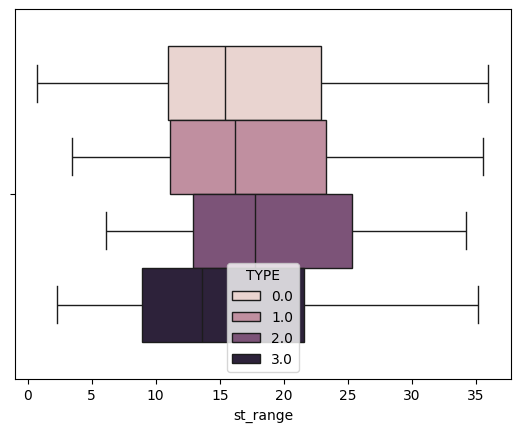

In [516]:
sns.boxplot(data=plus, x=plus["st_range"], hue = plus["TYPE"])

<Axes: xlabel='prom_slypersec', ylabel='Count'>

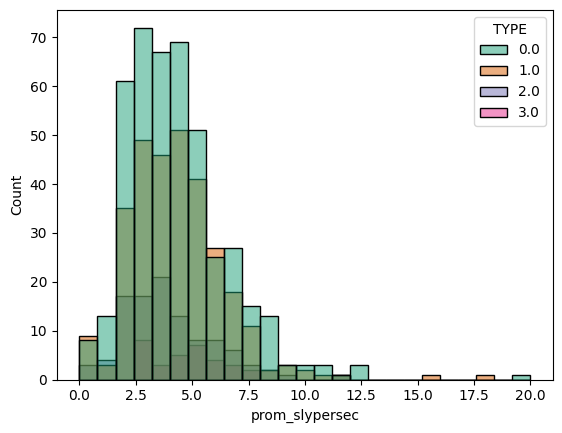

In [517]:
plus = plus[plus.prom_slypersec != 33.33]
sns.histplot(data=plus, x="prom_slypersec", hue = "TYPE", bins = 25, palette="Dark2")

<Axes: xlabel='prom_slypersec'>

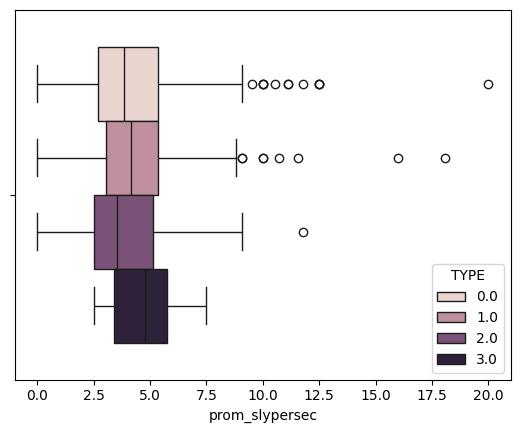

In [518]:
sns.boxplot(data=plus, x=plus["prom_slypersec"], hue = plus["TYPE"])

In [519]:
#plus = plus["TYPE"] == 1
sar = plus.loc[plus["TYPE"] == 2, "prom_slypersec"] 
sin = plus.loc[plus["TYPE"] == 0, "prom_slypersec"]
sin.mean()
#sar.mean()

np.float64(4.302347713710254)

In [520]:
sar.mean()

np.float64(3.9507102114552333)

In [521]:
plus.head()

,index,SCENE,SPEAKER,SHOW,Sarcasm,QUESTION?,GENDER,TYPE,TRANSCRIPT,wrd_count,...,st_range,mean_db_fix,sd_db_fix,range_db_fix,syl_count,slypersec,prom_syl_count,prom_duration,prom_word,prom_slypersec
0,0,1_10004_u,SHELDON,BBT,False,True,M,0.0,and of those few months how long have you been a demented sex pervert,14,...,14.460771,-0.050191,0.755288,4.221109,17,-0.557184,3,0.43,demented,6.976744
1,1,1_10009_u,PENNY,BBT,False,True,F,0.0,let the dead man talk so why do you think that,11,...,15.798789,0.352423,0.705045,2.858208,11,-0.176867,1,0.37,talk,2.702703
2,5,1_10495_u,AMY,BBT,True,False,F,1.0,and if it turns out you dont you and i could live together you and oh sure,17,...,14.911827,0.225187,0.800627,4.398985,18,-0.41013,1,0.14,oh,7.142857
3,7,1_105_u,SHELDON,BBT,True,False,M,3.0,im just inferring this is a couch because the evidence suggests the coffee table is having a tiny garage sale,20,...,21.267246,1.597864,0.539632,2.576688,31,1.20023,3,0.49,inferring,6.122449
4,8,1_10748_u,AMY,BBT,True,False,F,1.0,there they go fighting again youd never hear her talk that way to sauvignon blanc,15,...,9.333456,0.344365,0.640231,3.145372,19,-0.205034,2,0.44,fighting,4.545455


## SPEECH RATE FOR NON PROMINENT WORDS

In [522]:
plus['nonprom_slypersec'] = None
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words")
        prom_intervals = get_times_from_textgrid(path, "p")
        prom_timepoint = prom_intervals[0][1]
        print(word_intervals)
        #total_dur = plus.loc[idx, 'duration']
        #total_syl = plus.loc[idx, "syl_count"]
        #print(total_syl)

        nonprom_duration = plus.loc[idx, 'duration'] - plus.loc[idx, 'prom_duration']
        nonprom_syl_count = plus.loc[idx, "syl_count"] - plus.loc[idx, "prom_syl_count"]
        #print(nonprom_syl_count)
        #print(nonprom_duration)
        #print(nonprom_syl_count/nonprom_duration)
        
        plus.loc[idx, 'nonprom_slypersec'] = nonprom_syl_count/nonprom_duration

    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")


2026-01-25 20:40:34,447 - ERROR    - Exception occurred while processing request: object of type 'NoneType' has no len()
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1603, in get_processes
    [_load_process(data_id) for data_id in global_state.keys()],
     ~~~~~~~~~~~~~^^^^^^^^^
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1588, in _load_process
    rows=len(data),
         ~~~^^^^^^
TypeError: object of type 'NoneType' has no len()


[['and', 0.03, 0.26], ['of', 0.26, 0.43], ['those', 0.43, 0.69], ['few', 0.69, 0.94], ['months', 0.94, 1.43], ['how', 1.67, 1.85], ['long', 1.85, 2.18], ['have', 2.18, 2.46], ['you', 2.46, 2.6], ['been', 2.6, 2.78], ['a', 2.78, 2.84], ['demented', 2.84, 3.27], ['sex', 3.27, 3.51], ['pervert', 3.51, 3.89]]
[['let', 0.0, 0.33], ['the', 0.33, 0.39], ['dead', 0.39, 0.66], ['man', 0.66, 0.88], ['talk', 0.88, 1.25], ['so', 1.25, 1.32], ['why', 1.32, 1.67], ['do', 1.67, 1.73], ['you', 1.73, 1.81], ['think', 1.81, 2.02], ['that', 2.02, 2.2]]
[['and', 0.03, 0.12], ['if', 0.12, 0.25], ['it', 0.25, 0.34], ['turns', 0.34, 0.59], ['out', 0.59, 0.8], ['you', 0.8, 0.87], ['dont', 0.87, 1.37], ['you', 1.37, 1.49], ['and', 1.49, 1.6], ['i', 1.6, 1.73], ['could', 1.73, 1.89], ['live', 1.89, 2.05], ['together', 2.05, 2.58], ['you', 2.63, 2.69], ['and', 2.69, 3.06], ['oh', 3.06, 3.2], ['sure', 3.2, 3.8]]
[['im', 0.0, 0.14], ['just', 0.14, 0.29], ['inferring', 0.29, 0.78], ['this', 0.78, 0.99], ['is', 0.99

In [523]:
for idx, key in plus['SCENE'].items():
    try:
        speaker = plus.loc[idx, 'SPEAKER']
        unnorm_speechrate = plus.loc[idx, 'nonprom_slypersec']
        norm_speechrate = (unnorm_speechrate - speaker_meanspeechrate[speaker])/speaker_sdspeechrate[speaker]
        plus.loc[idx, 'nonprom_slypersec'] = norm_speechrate
        
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")
        

In [524]:
plus = plus.drop(columns=[ 'prom_duration','prom_syl_count'])

In [525]:
#negative = prom word is faster than rest
# positive = prom word is slower than rest
plus['speech_rate_diff'] = plus['nonprom_slypersec']-plus['prom_slypersec']

In [526]:
dtale.show(plus)

<Axes: xlabel='speech_rate_diff'>

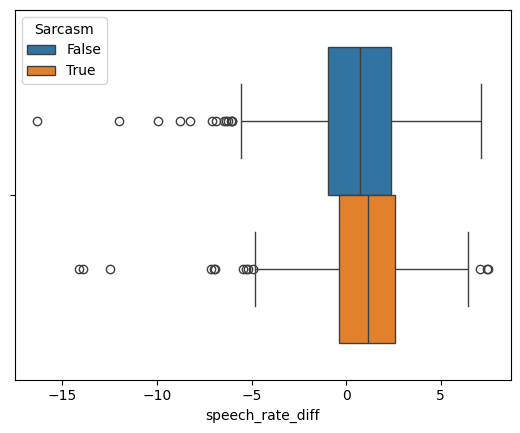

In [527]:
sns.boxplot(data=plus, x=plus["speech_rate_diff"], hue = plus["Sarcasm"])

## LEG COEF FOR PROMINENT WORDS

In [528]:
plus['prom_1_pitch']=None
plus['prom_2_pitch']=None
plus['prom_3_pitch']=None
plus['prom_4_pitch']=None

plus['prom_1_intensity']=None
plus['prom_2_intensity']=None
plus['prom_3_intensity']=None
plus['prom_4_intensity']=None
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words")
        prom_intervals = get_times_from_textgrid(path, "p")
        prom_timepoint = prom_intervals[0][1]
        
        for word in word_intervals:
            start = word[1]
            end = word[2]
            if start < prom_timepoint < end:
                prom_start = start
                prom_end = end
                prom_word = word[0]
                break
        #prom_duration = prom_end-prom_start
        try:
            wav_path = None
            for root, dirs, files in os.walk(base_dir):
                target_file = f"{key}.wav"
                if target_file in files:
                    wav_path = os.path.join(root, target_file)
                    break

            if wav_path is None:
                raise FileNotFoundError(f"srry bb I can't find {key} idk...")
            #print(type(wav_path))
            sound = parselmouth.Sound(wav_path)
            prom_contour_pitch, prom_contour_intensity = get_contours (sound, prom_start , prom_end, keep_zeros = False)
            speaker_mean = plus.loc[idx, "speaker_mean_f0"]
            #print(wav_path)
            #print(prom_contour_pitch[4])
            prom_contour_pitch = f2st(prom_contour_pitch, speaker_mean)
            #print(prom_contour_pitch[4])
            #print(prom_contour_pitch.dtype())
            #prom_contour_pitch = scipy.stats.zscore(prom_contour_pitch)
            #prom_contour_intensity = scipy.stats.zscore(prom_contour_intensity)
            #print(prom_contour_pitch)
            prom_leg_pitch = get_legendres(prom_contour_pitch , n=4)
            pitch_1 = prom_leg_pitch[0]
            pitch_2 = prom_leg_pitch[1]
            pitch_3 = prom_leg_pitch[2]
            pitch_4 = prom_leg_pitch[3]
            speaker = plus.loc[idx, 'SPEAKER']

            prom_contour_intensity = (prom_contour_intensity - speaker_contours_means_inten[speaker])/speaker_contours_sds_inten[speaker]
            prom_leg_intensity = get_legendres(prom_contour_intensity , n=4)
            intensity_1 = prom_leg_intensity[0]
            intensity_2 = prom_leg_intensity[1]
            intensity_3 = prom_leg_intensity[2]
            intensity_4 = prom_leg_intensity[3]
            plus.loc[idx, ['prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch',
                           'prom_1_intensity','prom_2_intensity','prom_3_intensity','prom_4_intensity']] = [[
                pitch_1, pitch_2, pitch_3, pitch_4, intensity_1, intensity_2, intensity_3, intensity_4]]
            #print(pitch_1)
            #print(pitch_2)
            #print(prom_leg_intensity)
        except Exception as e:
            print(f"oh noses u have a problem in {wav_path}: {e}")
        """
        print(path)
        print(f"start time {prom_start}")
        print(f"end time {prom_end}")
        print(f"prom word {prom_word}")
        """
    except Exception as e:
        print(f"oh noses u have a problem in {path}: {e}")
plus[['prom_1_pitch', 'prom_2_pitch', 'prom_3_pitch','prom_4_pitch',
      'prom_1_intensity','prom_2_intensity','prom_3_intensity','prom_4_intensity']] = (
    plus[['prom_1_pitch', 'prom_2_pitch','prom_3_pitch','prom_4_pitch',
          'prom_1_intensity','prom_2_intensity','prom_3_intensity','prom_4_intensity']].apply(lambda col: col.str[0])
)
 

2026-01-25 20:41:07,045 - ERROR    - Exception occurred while processing request: object of type 'NoneType' has no len()
Traceback (most recent call last):
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 121, in _handle_exceptions
    return func(*args, **kwargs)
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1603, in get_processes
    [_load_process(data_id) for data_id in global_state.keys()],
     ~~~~~~~~~~~~~^^^^^^^^^
  File "C:\Users\kasia\AppData\Local\Programs\Python\Python313\Lib\site-packages\dtale\views.py", line 1588, in _load_process
    rows=len(data),
         ~~~^^^^^^
TypeError: object of type 'NoneType' has no len()


In [529]:
#expect: 872
print(len(plus)) 

872


In [936]:
dtale.show(plus)

# DISPLAY CONTOUR FROM ONE UTTERANCE

-6.202812446646075
-1.5442734954333828
0.4901035843422461
-0.23417125295764907


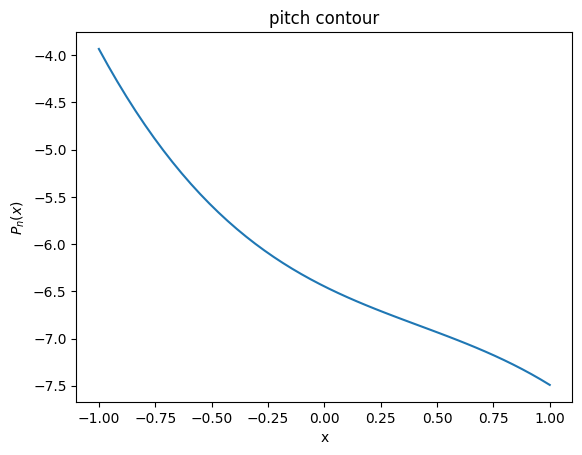

In [531]:
#PITCH
ind = plus[plus['SCENE'] == '1_10009_u'] # scene name here
#print(ind)
polys = ind[['prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch']]
polys = polys.values.flatten().tolist()
#print(ploys)
X = np.linspace(-1, 1)
fff = dict(enumerate(polys))
#print(fff)
y=0
for m in range(0, 4):
    print(fff[m])
    poly = eval_legendre(m, X) * fff[m]
        #if m > 1:
    y += poly
plt.plot(X, y)
plt.title("pitch contour")
plt.xlabel("x")
plt.ylabel(r'$P_n(x)$')
plt.show()

# KMEANS 

In [631]:
plus['cluster_allpitch']=None
plus['cluster_allintensity']=None

### KAY

In [55]:
kay = 4

### LEGENDRES PITCH

In [56]:
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import eval_legendre

In [57]:
all_coefs_pitch = plus[['prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch']]
#all_coefs_pitch = plus[['prom_3_pitch','prom_4_pitch']]
all_coefs_pitch.head()

,prom_1_pitch,prom_2_pitch,prom_3_pitch,prom_4_pitch
0,-9.222264,1.441297,0.864311,1.053329
1,-6.202812,-1.544273,0.490104,-0.234171
2,-23.654239,-1.068646,-2.006175,-0.264643
3,4.608558,1.162753,-1.363632,-0.678065
4,-4.846450,-0.160409,-0.436584,-0.738787


[[-4.21223426e+00 -4.45106463e-01 -4.40841496e-01 -1.21105107e-01]
 [ 4.18083140e+00  1.70685059e-01 -4.22008951e-01 -4.79864910e-02]
 [-1.31175121e+01 -3.70703767e-01 -8.34512980e-01 -1.13562635e-02]
 [ 1.58156600e+01  7.43981886e-01  2.25953302e-01 -4.03499861e-02]]
[2 0 2 1 0 2 1 2 2 1 1 2 0 1 2 3 0 1 0 1 3 0 1 0 0 1 2 1 0 1 3 3 0 0 2 2 1
 0 2 1 0 0 2 0 1 1 2 0 2 3 0 2 0 3 2 1 2 3 2 3 3 0 3 3 0 2 1 0 3 0 0 1 0 2
 1 3 1 2 2 0 3 0 2 2 1 1 0 1 0 0 2 0 0 2 2 2 0 0 1 2 1 0 0 3 1 0 0 2 1 0 0
 2 3 1 0 1 0 1 3 3 0 0 0 3 0 3 1 0 0 0 3 3 0 2 2 0 2 0 0 1 0 1 0 0 0 2 0 2
 2 1 3 0 0 0 1 3 0 2 1 3 1 3 2 2 0 2 2 2 3 0 3 1 0 2 1 0 0 2 0 3 1 2 1 2 2
 2 0 1 1 0 1 0 0 1 1 2 2 0 0 0 3 2 0 3 2 1 0 0 0 3 2 2 1 2 0 0 2 0 1 2 0 2
 0 0 3 1 2 2 0 2 0 0 1 3 2 0 2 0 0 1 1 0 0 1 1 0 1 2 1 1 0 1 2 1 0 0 2 0 1
 0 0 0 1 0 0 3 3 0 1 0 2 2 2 3 1 1 0 3 1 3 2 2 2 1 1 1 0 1 2 1 0 2 0 0 0 0
 0 2 1 2 0 3 3 2 0 3 0 1 2 1 2 1 0 3 1 0 1 3 2 0 1 0 0 3 2 1 0 0 2 0 0 0 2
 0 3 2 0 1 0 1 0 2 1 2 2 1 2 0 1 1 1 1 0 1 2 0 0 3 3 3 3

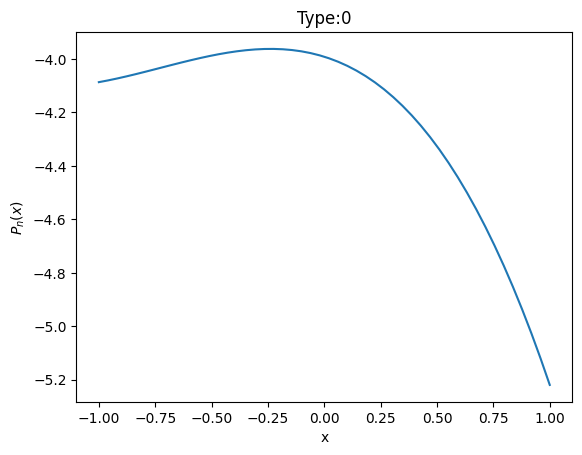

{0: np.float64(4.180831396363061), 1: np.float64(0.17068505871890277), 2: np.float64(-0.4220089508496989), 3: np.float64(-0.047986490966803144)}
4.180831396363061
0.17068505871890277
-0.4220089508496989
-0.047986490966803144


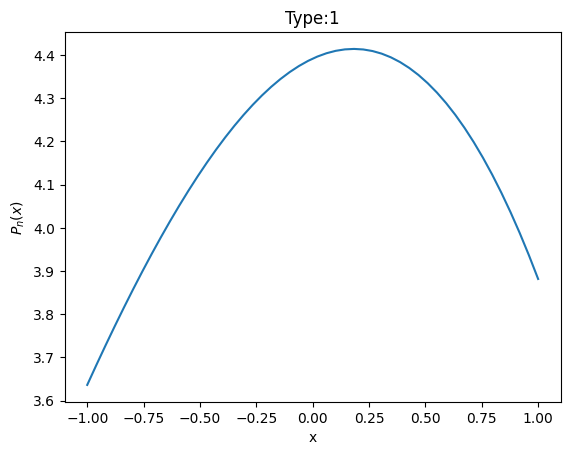

{0: np.float64(-13.11751206374373), 1: np.float64(-0.3707037667761043), 2: np.float64(-0.8345129801321227), 3: np.float64(-0.011356263529376305)}
-13.11751206374373
-0.3707037667761043
-0.8345129801321227
-0.011356263529376305


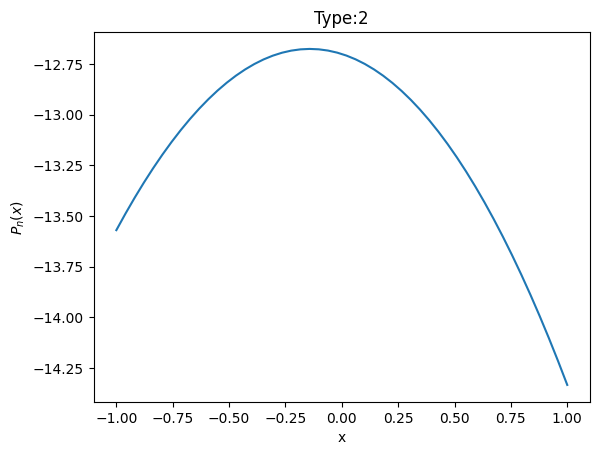

{0: np.float64(15.815659983971052), 1: np.float64(0.7439818861027887), 2: np.float64(0.22595330174715955), 3: np.float64(-0.040349986076677447)}
15.815659983971052
0.7439818861027887
0.22595330174715955
-0.040349986076677447


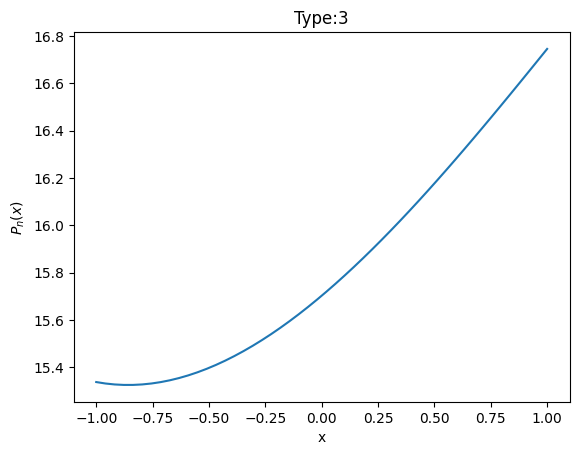

In [65]:
from sklearn.cluster import KMeans
k = KMeans(init='random', n_clusters=kay, random_state=1)
plus['cluster_allpitch'] = k.fit_predict(all_coefs_pitch)
#print(center)
center = k.cluster_centers_
#print(center)
print(k.cluster_centers_)
print(k.labels_)
dicts = []
for n in range(kay):
    d = dict(enumerate(center[n]))
    dicts.append(d)
a, b, c, d = dicts[:4]

X = np.linspace(-1, 1)
for n in range(0,kay):
    fff = dicts[n]
    print(fff)
    y=0
    for m in range(0, 4):
        print(fff[m])
        poly = eval_legendre(m, X) * fff[m]
        #if m > 1:
        y += poly
    plt.plot(X, y)
    plt.title("Type:" + str(n))
    plt.xlabel("x")
    plt.ylabel(r'$P_n(x)$')
    plt.show()
    n+=1

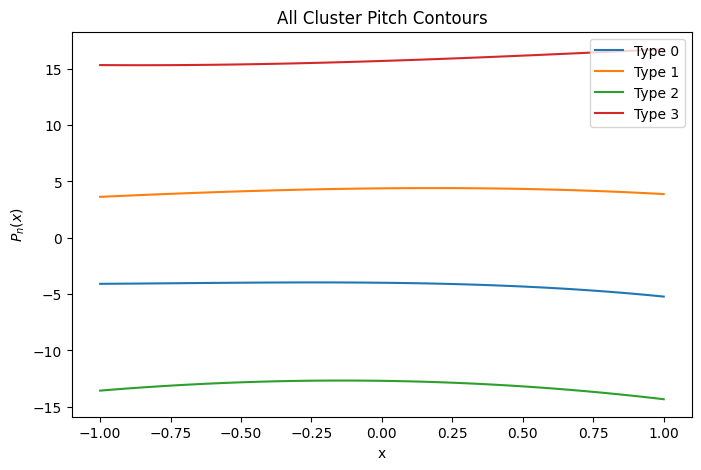

In [68]:
X = np.linspace(-1, 1)

plt.figure(figsize=(8,5))

for n in range(0, kay):
    fff = dicts[n]
    y = 0
    for m in range(0, 4):
        poly = eval_legendre(m, X) * fff[m]
        y += poly
    plt.plot(X, y, label=f"Type {n}")

plt.title("All Cluster Pitch Contours")
plt.xlabel("x")
plt.ylabel(r'$P_n(x)$')
plt.legend()
plt.show()

### LEGENDRES INTENSITY

In [830]:
all_coefs_intensity = plus[['prom_1_intensity','prom_2_intensity','prom_3_intensity','prom_4_intensity']]
#print(all_coefs_intensity)
#print(all_coefs_intensity == None)
from sklearn.cluster import KMeans
k = KMeans(init='random', n_clusters=kay, random_state=45)
plus['cluster_allintensity'] = k.fit_predict(all_coefs_intensity)
print(k.cluster_centers_)

[[ 2.29934212 -0.01119644 -0.0206748   0.01669775]
 [ 1.04665542 -0.0254222  -0.13382121  0.02120562]
 [ 0.0033649   0.01403903 -0.17740766  0.00758808]
 [-1.28431814 -0.0044646  -0.21637919  0.02497645]]


[[ 2.29934212 -0.01119644 -0.0206748   0.01669775]
 [ 1.04665542 -0.0254222  -0.13382121  0.02120562]
 [ 0.0033649   0.01403903 -0.17740766  0.00758808]
 [-1.28431814 -0.0044646  -0.21637919  0.02497645]]
{0: np.float64(2.299342120068314), 1: np.float64(-0.011196440637224893), 2: np.float64(-0.020674798845539508), 3: np.float64(0.016697747818065392)}
2.299342120068314
-0.011196440637224893
-0.020674798845539508
0.016697747818065392


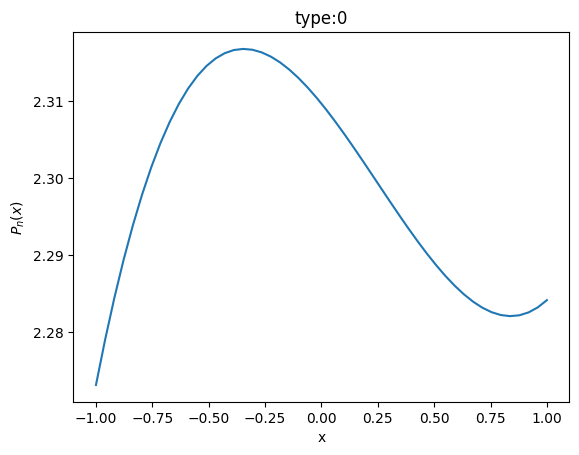

{0: np.float64(1.0466554194908724), 1: np.float64(-0.02542219832144291), 2: np.float64(-0.13382121306557535), 3: np.float64(0.02120561582661588)}
1.0466554194908724
-0.02542219832144291
-0.13382121306557535
0.02120561582661588


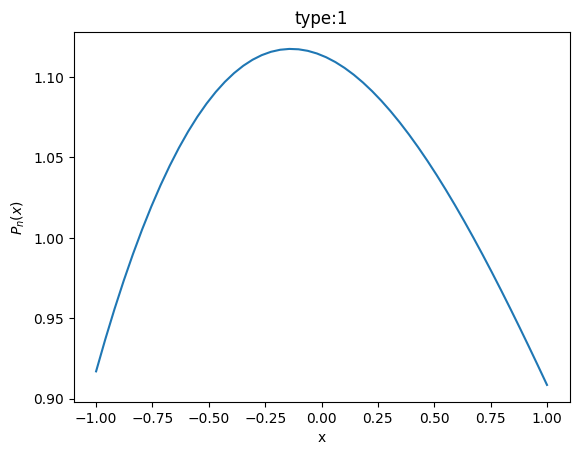

{0: np.float64(0.003364901767642592), 1: np.float64(0.01403902522395276), 2: np.float64(-0.17740766021964113), 3: np.float64(0.007588083791088881)}
0.003364901767642592
0.01403902522395276
-0.17740766021964113
0.007588083791088881


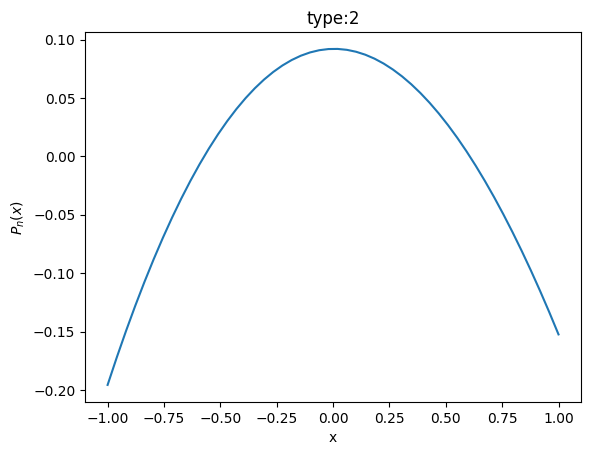

{0: np.float64(-1.2843181443430205), 1: np.float64(-0.004464599748844044), 2: np.float64(-0.2163791892015074), 3: np.float64(0.024976450228586376)}
-1.2843181443430205
-0.004464599748844044
-0.2163791892015074
0.024976450228586376


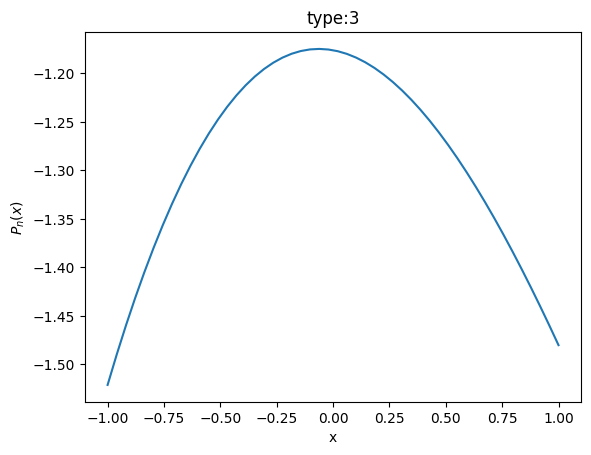

In [831]:
center = k.cluster_centers_
#print(center)
print(k.cluster_centers_)
#all_coefs_pitch[0]
X = np.linspace(-1, 1)
for n in range(0,kay):
    fff = dict(enumerate(center[n]))
    print(fff)
    y=0
    for m in range(0, 4):
        print(fff[m])
        poly = eval_legendre(m, X) * fff[m]
        y += poly
    plt.plot(X, y)
    plt.title("type:" +str(n))
    plt.xlabel("x")
    plt.ylabel(r'$P_n(x)$')
    plt.show()
    n+=1

In [832]:
plus.head()

,index,SCENE,SPEAKER,SHOW,Sarcasm,QUESTION?,GENDER,TYPE,TRANSCRIPT,wrd_count,...,prom_1_pitch,prom_2_pitch,prom_3_pitch,prom_4_pitch,prom_1_intensity,prom_2_intensity,prom_3_intensity,prom_4_intensity,cluster_allpitch,cluster_allintensity
0,0,1_10004_u,SHELDON,BBT,0,True,M,0.0,and of those few months how long have you been a demented sex pervert,14,...,-9.222264,1.441297,0.864311,1.053329,0.293812,-0.126631,-0.339739,0.063407,2,2
1,1,1_10009_u,PENNY,BBT,0,True,F,0.0,let the dead man talk so why do you think that,11,...,-6.202812,-1.544273,0.490104,-0.234171,0.557118,-0.114723,-0.759631,-0.119670,0,1
2,5,1_10495_u,AMY,BBT,1,False,F,1.0,and if it turns out you dont you and i could live together you and oh sure,17,...,-23.654239,-1.068646,-2.006175,-0.264643,0.094997,-0.354919,-0.126248,-0.104076,2,2
3,7,1_105_u,SHELDON,BBT,1,False,M,3.0,im just inferring this is a couch because the evidence suggests the coffee table is having a tiny garage sale,20,...,4.608558,1.162753,-1.363632,-0.678065,3.429814,0.140829,0.177356,-0.263512,1,0
4,8,1_10748_u,AMY,BBT,1,False,F,1.0,there they go fighting again youd never hear her talk that way to sauvignon blanc,15,...,-4.846450,-0.160409,-0.436584,-0.738787,0.209358,0.526508,-0.220975,-0.138370,0,2


### LEGENDRE TYPE FREQUENCY

2026-01-26 22:38:38,698 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-26 22:38:38,707 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='cluster_allpitch', ylabel='count'>

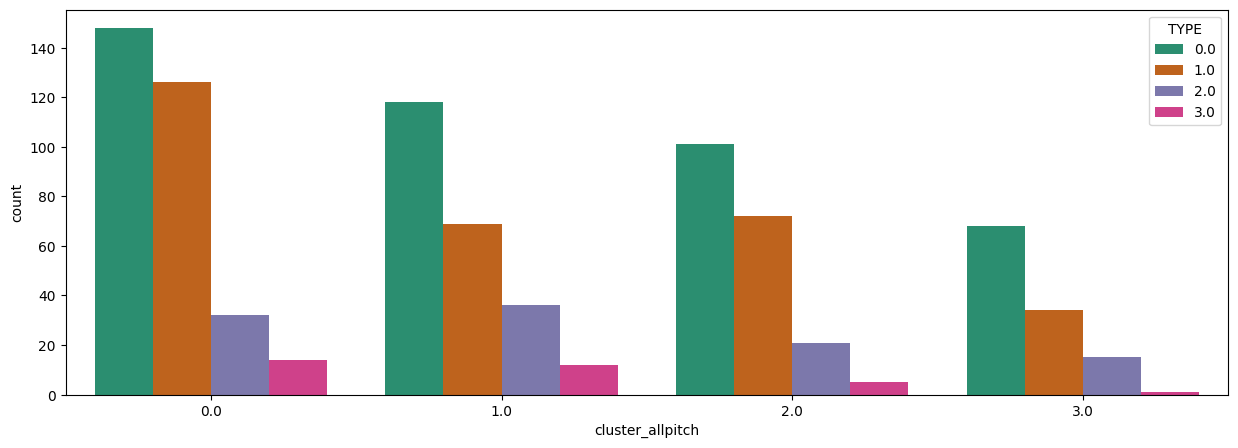

In [52]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="cluster_allpitch", hue = "TYPE",palette="Dark2")

2026-01-26 22:38:38,998 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-26 22:38:39,004 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='cluster_allpitch', ylabel='count'>

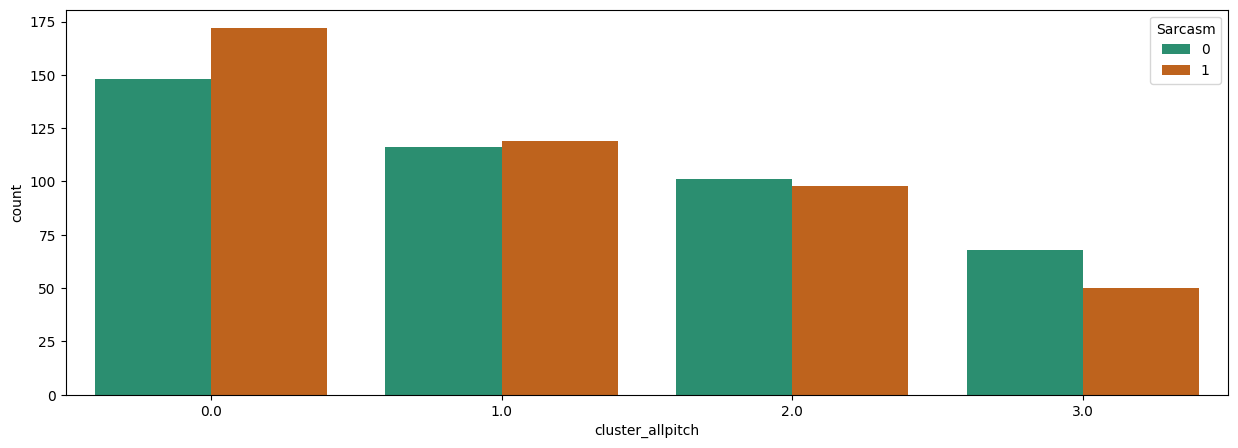

In [53]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="cluster_allpitch", hue = "Sarcasm",palette="Dark2")

2026-01-26 22:38:44,672 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-26 22:38:44,679 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='cluster_allintensity', ylabel='count'>

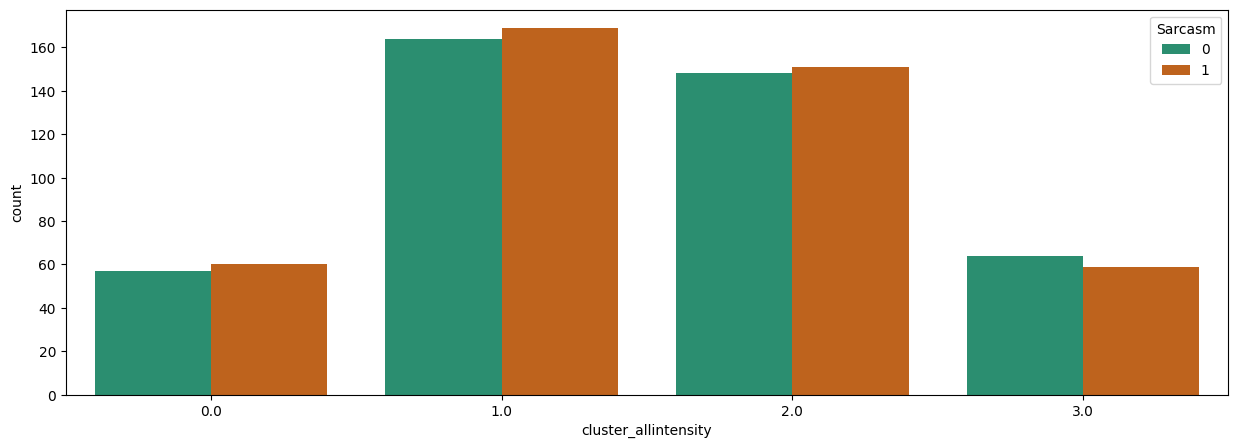

In [54]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="cluster_allintensity", hue = "Sarcasm",palette="Dark2")

-6.202812446646075
-1.5442734954333828
0.4901035843422461
-0.23417125295764907


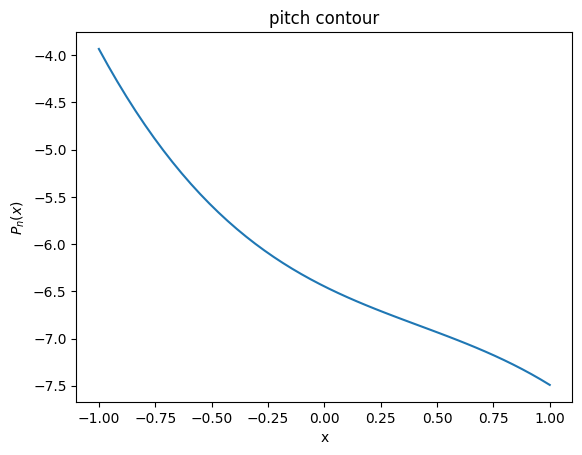

In [554]:

ind = plus[plus['SCENE'] == '1_10009_u'] # scene name here
#print(ind)
polys = ind[['prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch']]
polys = polys.values.flatten().tolist()
#print(ploys)
X = np.linspace(-1, 1)
fff = dict(enumerate(polys))
#print(fff)
y=0
for m in range(0, 4):
    print(fff[m])
    poly = eval_legendre(m, X) * fff[m]
        #if m > 1:
    y += poly
plt.plot(X, y)
plt.title("pitch contour")
plt.xlabel("x")
plt.ylabel(r'$P_n(x)$')
plt.show()

## PITCH

In [86]:
import numpy as np
from itertools import combinations

data = plus[['prom_1_pitch', 'prom_2_pitch','prom_3_pitch','prom_4_pitch']].to_numpy()
y = plus["Sarcasm"].to_numpy()
cannot_link = [(i, j) for i, j in combinations(range(len(y)), 2) if y[i] != y[j]]

In [87]:
from copkmeans.cop_kmeans import cop_kmeans
clusters, centers = cop_kmeans(dataset = data, k = 5, cl=cannot_link)

In [88]:
print(centers)

[[np.float64(1.6112368593721576e-16), np.float64(0.8121298534660571), np.float64(-0.16125779361883003), np.float64(0.04582369264827236)], [np.float64(2.0845531516988612e-16), np.float64(-0.8247558281058124), np.float64(-0.1098614973981829), np.float64(-0.10209451729830746)], [np.float64(9.213497182984137e-17), np.float64(0.02158736966500917), np.float64(-0.7068782990882363), np.float64(-0.06342005469605298)], [np.float64(-1.533032438038762e-16), np.float64(0.9566091925738096), np.float64(-0.04414245648000158), np.float64(0.05681481082595714)], [np.float64(-1.5832131936337134e-16), np.float64(-0.9221145121670012), np.float64(-0.022981358548767216), np.float64(-0.10305613777649167)]]


In [89]:
#cluster 0 = sin
#cluster 1 = sar
#cluster 2 = sar
#cluster 3 = sin
print(len(clusters))
print(clusters)
plus['COP_clusters_pitch'] = clusters

872
[0, 1, 4, 2, 2, 1, 3, 0, 1, 1, 1, 3, 4, 0, 1, 3, 0, 2, 4, 3, 3, 1, 0, 3, 4, 3, 4, 0, 0, 4, 4, 0, 1, 0, 3, 4, 0, 1, 1, 4, 0, 0, 2, 1, 3, 0, 3, 4, 0, 4, 0, 1, 4, 3, 2, 4, 3, 3, 3, 0, 1, 3, 0, 0, 0, 4, 0, 3, 4, 0, 1, 0, 2, 2, 1, 2, 0, 2, 1, 1, 3, 0, 4, 4, 1, 0, 3, 4, 3, 1, 0, 3, 4, 1, 0, 1, 1, 1, 1, 4, 1, 0, 2, 3, 3, 1, 4, 4, 1, 4, 0, 4, 4, 3, 3, 3, 1, 4, 0, 3, 4, 4, 4, 4, 0, 0, 1, 4, 4, 2, 0, 4, 3, 3, 2, 0, 0, 2, 4, 0, 1, 1, 1, 4, 2, 3, 4, 4, 2, 0, 4, 1, 0, 1, 1, 1, 4, 1, 0, 0, 4, 1, 1, 3, 4, 0, 4, 1, 0, 0, 4, 4, 4, 3, 2, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 3, 3, 3, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 4, 0, 0, 1, 1, 0, 1, 2, 3, 4, 4, 4, 4, 4, 4, 4, 2, 4, 4, 2, 4, 3, 3, 4, 3, 4, 3, 3, 4, 2, 4, 4, 4, 3, 4, 3, 4, 3, 4, 4, 4, 3, 0, 0, 0, 4, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 4, 4, 0, 0, 3, 0, 4, 3, 1, 0, 0, 1, 1, 4, 0, 2, 1, 0, 2, 3, 4, 4, 2, 4, 3, 4, 4, 3, 2, 4, 3, 4, 4, 4, 2, 4, 3, 2, 3, 4, 1, 1, 4, 0, 1, 3, 1, 0, 0, 0, 1, 1, 1, 1, 3, 1, 0, 0, 1, 1, 1,

In [90]:
plus.head(4)

,index,SCENE,SPEAKER,SHOW,Sarcasm,QUESTION?,GENDER,TYPE,TRANSCRIPT,wrd_count,...,prom_2_pitch,prom_3_pitch,prom_4_pitch,prom_1_intensity,prom_2_intensity,prom_3_intensity,prom_4_intensity,cluster_allpitch,cluster_allintensity,COP_clusters_pitch
0,0,1_10004_u,SHELDON,BBT,False,True,M,0.0,and of those few months how long have you been a demented sex pervert,14,...,0.576376,0.453882,0.423321,9.171408e-16,-0.242795,-0.663912,0.121573,1,3,0
1,1,1_10009_u,PENNY,BBT,False,True,F,0.0,let the dead man talk so why do you think that,11,...,-0.999304,0.488761,-0.166544,-1.298107e-15,-0.128783,-0.869190,-0.134336,3,3,1
2,5,1_10495_u,AMY,BBT,True,False,F,1.0,and if it turns out you dont you and i could live together you and oh sure,17,...,-1.151390,0.403270,-0.302809,1.865175e-15,-1.122167,-0.432539,-0.329064,3,2,4
3,7,1_105_u,SHELDON,BBT,True,False,M,3.0,im just inferring this is a couch because the evidence suggests the coffee table is having a tiny garage sale,20,...,0.509507,-0.671132,-0.312474,-2.817705e-15,0.292923,0.234295,-0.548103,0,0,2


{0: np.float64(1.6112368593721576e-16), 1: np.float64(0.8121298534660571), 2: np.float64(-0.16125779361883003), 3: np.float64(0.04582369264827236)}
1.6112368593721576e-16
0.8121298534660571
-0.16125779361883003
0.04582369264827236


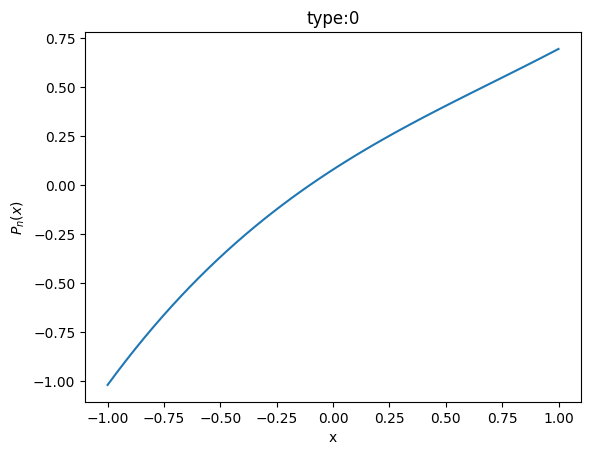

{0: np.float64(2.0845531516988612e-16), 1: np.float64(-0.8247558281058124), 2: np.float64(-0.1098614973981829), 3: np.float64(-0.10209451729830746)}
2.0845531516988612e-16
-0.8247558281058124
-0.1098614973981829
-0.10209451729830746


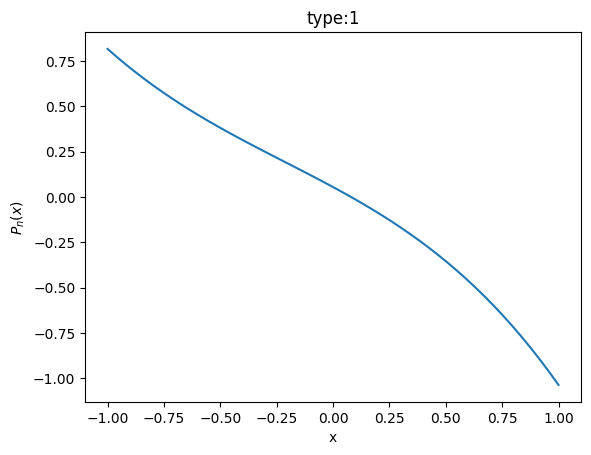

{0: np.float64(9.213497182984137e-17), 1: np.float64(0.02158736966500917), 2: np.float64(-0.7068782990882363), 3: np.float64(-0.06342005469605298)}
9.213497182984137e-17
0.02158736966500917
-0.7068782990882363
-0.06342005469605298


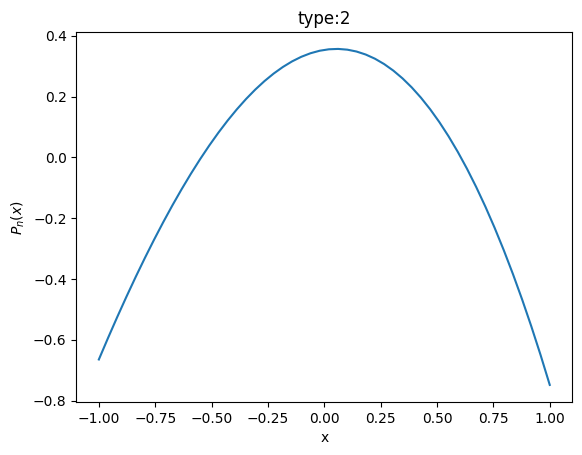

{0: np.float64(-1.533032438038762e-16), 1: np.float64(0.9566091925738096), 2: np.float64(-0.04414245648000158), 3: np.float64(0.05681481082595714)}
-1.533032438038762e-16
0.9566091925738096
-0.04414245648000158
0.05681481082595714


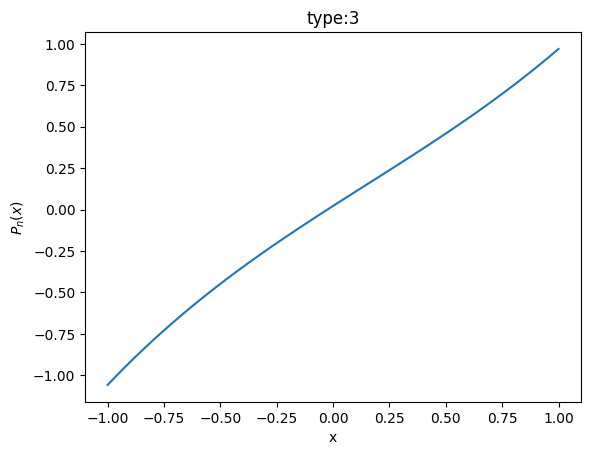

{0: np.float64(-1.5832131936337134e-16), 1: np.float64(-0.9221145121670012), 2: np.float64(-0.022981358548767216), 3: np.float64(-0.10305613777649167)}
-1.5832131936337134e-16
-0.9221145121670012
-0.022981358548767216
-0.10305613777649167


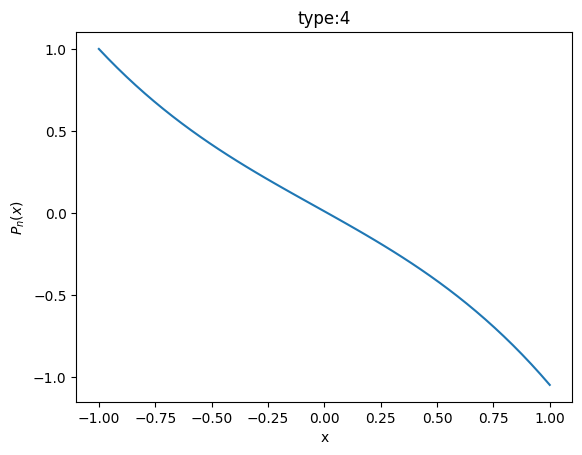

In [91]:
X = np.linspace(-1, 1)
for n in range(0,5):
    fff = dict(enumerate(centers[n]))
    print(fff)
    y=0
    for m in range(0, 4):
        print(fff[m])
        poly = eval_legendre(m, X) * fff[m]
        y += poly
    plt.plot(X, y)
    plt.title("type:" +str(n))
    plt.xlabel("x")
    plt.ylabel(r'$P_n(x)$')
    plt.show()
    n+=1

## INTENSITY

In [92]:
import numpy as np
from itertools import combinations

# Extract feature matrix and labels
data = plus[['prom_1_intensity','prom_2_intensity', 'prom_3_intensity','prom_4_intensity']].to_numpy()
y = plus["Sarcasm"].to_numpy()

# Build cannot-link constraints: all pairs where labels differ
cannot_link = [(i, j) for i, j in combinations(range(len(y)), 2) if y[i] != y[j]]

In [93]:
from copkmeans.cop_kmeans import cop_kmeans
clusters, centers = cop_kmeans(dataset = data, k = 4, cl=cannot_link)

In [94]:
print(centers)
print(len(clusters))
print(clusters)
plus['COP_clusters_intensity'] = clusters

[[np.float64(5.00519578734848e-16), np.float64(0.5368703652581439), np.float64(-0.33419100150484066), np.float64(0.056833811399813285)], [np.float64(-2.4057240415861535e-16), np.float64(-0.6245339148905973), np.float64(-0.22380591128422772), np.float64(0.00017543746132204786)], [np.float64(1.8216695104067992e-16), np.float64(0.5238575508530959), np.float64(-0.36533539691251743), np.float64(0.055586099628719104)], [np.float64(2.2769088244443564e-16), np.float64(-0.6159967703751262), np.float64(-0.2808341859517167), np.float64(0.03328511577667109)]]
872
[3, 3, 1, 0, 0, 2, 1, 3, 2, 3, 2, 1, 1, 3, 2, 0, 2, 1, 0, 1, 1, 2, 2, 1, 1, 1, 0, 2, 3, 1, 1, 2, 2, 3, 1, 0, 2, 3, 2, 0, 2, 3, 0, 2, 0, 2, 0, 1, 3, 0, 3, 3, 0, 1, 1, 1, 0, 0, 0, 3, 3, 1, 2, 3, 3, 0, 2, 0, 0, 3, 3, 3, 0, 1, 3, 0, 3, 1, 3, 2, 1, 2, 0, 0, 3, 2, 1, 0, 0, 2, 3, 0, 0, 2, 3, 2, 2, 3, 3, 1, 2, 2, 0, 0, 0, 2, 1, 1, 2, 0, 3, 1, 0, 1, 0, 1, 2, 0, 3, 0, 1, 0, 0, 0, 2, 2, 2, 0, 1, 1, 3, 1, 0, 0, 0, 2, 2, 0, 0, 2, 3, 2, 3, 0, 1, 1, 1, 

In [95]:
#finds mean pitch in hz for each speaker
speakeravg = plus.groupby("SPEAKER")["mean_F0"].mean().to_dict()
print(speakeravg['AMY'])
print(speakeravg)

224.79080189574753
{'AMY': 224.79080189574753, 'BERNADETTE': 286.70467682020126, 'CHANDLER': 191.4009419872752, 'DOROTHY': 169.95584384044804, 'GILFOYLE': 105.25219091163383, 'HOWARD': 155.30856376022612, 'JOEY': 177.47938222549377, 'LEONARD': 162.5903293978065, 'MONICA': 303.67553434505413, 'PENNY': 252.6706430139552, 'PHOEBE': 307.4698790193512, 'RACHEL': 296.6868774709166, 'ROSS': 201.10299749597866, 'SHELDON': 174.82888884967178}


In [ ]:
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words")
        prom_intervals = get_times_from_textgrid(path, "p")
        prom_timepoint = prom_intervals[0][1]
        
        for word in word_intervals:
            start = word[1]
            end = word[2]
            if start < prom_timepoint < end:
                prom_start = start
                prom_end = end
                prom_word = word[0]
                break
        end_before = prom_start
        start_after = prom_end
        
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")
        
        sound = parselmouth.Sound(wav_path)
        duration = findDuration(sound)
        b_pitch_contour, b_intensity_contour = get_contours(sound, 0.0, end_before, keep_zeros=False)
        speaker = plus.loc[idx, 'SPEAKER']
        db_z_fix = (b_intensity_contour - speaker_contours_means[speaker])/speaker_contours_sds[speaker]
        mean_db_fix = get_mean(db_z_fix)
        range_db_fix = get_range(db_z_fix)
        sd_db_fix = get_sd(db_z_fix)
        
        plus.loc[idx, ['b_mean_db','b_range_db', 'b_sd_db']] = [mean_db_fix, range_db_fix, sd_db_fix]  

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [ ]:
speaker_contours = {} #ANDI, don't print this out! It will crash Jupyter notebook!!!! >:(
speaker_contours_means = {}
speaker_contours_sds = {}
for idx, row in plus.iterrows():
    speaker = row["SPEAKER"]
    contour = row["a_intensity_contour"]  

    if speaker not in speaker_contours:
        speaker_contours[speaker] = []

    speaker_contours[speaker].extend(contour)

for speaker in speaker_contours:
    ind_contour = speaker_contours[speaker]
    mean = sum(ind_contour)/len(ind_contour)
    sd = np.std(ind_contour, ddof=0) # 0 bc this is the population mean 
    speaker_contours_means[speaker] = mean
    speaker_contours_sds[speaker] = sd


In [ ]:
for idx, key in plus['SCENE'].items():
    try:
        path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.TextGrid"
            if target_file in files:
                path = os.path.join(root, target_file)
                break

        if path is None:
            raise FileNotFoundError(f"srry bb I can't find {key} idk...")

        ###find time interval of all words in textgrid
        word_intervals = get_times_from_textgrid(path, "words")
        prom_intervals = get_times_from_textgrid(path, "p")
        prom_timepoint = prom_intervals[0][1]
        
        for word in word_intervals:
            start = word[1]
            end = word[2]
            if start < prom_timepoint < end:
                prom_start = start
                prom_end = end
                prom_word = word[0]
                break
        end_before = prom_start
        start_after = prom_end
        
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")
        
        sound = parselmouth.Sound(wav_path)
        duration = findDuration(sound)
        #b_pitch_contour, b_intensity_contour = get_contours(sound, 0.0, end_before, keep_zeros=False)
        a_pitch_contour, a_intensity_contour = get_contours(sound, start_after, duration, keep_zeros=False)
        speaker = plus.loc[idx, 'SPEAKER']
        db_z_fix = (a_intensity_contour - speaker_contours_means[speaker])/speaker_contours_sds[speaker]
        mean_db_fix = get_mean(db_z_fix)
        range_db_fix = get_range(db_z_fix)
        sd_db_fix = get_sd(db_z_fix)
        
        plus.loc[idx, ['a_mean_db','a_range_db', 'a_sd_db']] = [mean_db_fix, range_db_fix, sd_db_fix]  

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [ ]:
for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")
        
        sound = parselmouth.Sound(wav_path)
        duration = findDuration(sound)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, end, keep_zeros=False)
        speaker_mean = plus.loc[idx, "speaker_mean_f0"]
        st_contour = f2st(pitch_contour, speaker_mean)
        #print(idx, st_contour)

        mean_st = get_mean(st_contour)
        range_st = get_range(st_contour)
        sd_st = get_sd(st_contour)
        plus.loc[idx, ["st_mean","st_sd","st_range"]] = [mean_st, sd_st, range_st,]

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [ ]:
from pydub import AudioSegment
import math
base_dir = r'C:\Users\kasia\asp2025\textgrids'

In [ ]:
def findDuration(sound):
    duration = call(sound, "Get total duration")
    return duration

In [ ]:
# Get intensity and pitch contours
def get_contours(sound, start_time, end_time, keep_zeros):
    """
    Extract F0 and intensity contours from wav file, within a given time frame
    :param wav_path: Full path to a single wav file
    :param keep_zeros: True if you want to keep zeros of F0 contour (i.e., keep spaces without an F0 measurement)
    :return: the F0 and intensity contours as lists
    """
    sound_interval = sound.extract_part(from_time=start_time, to_time=end_time)
    try: # This deals with if the extracted part is shorter than the window length
        pitch_contour = sound_interval.to_pitch().interpolate().selected_array['frequency']
        #pitch_contour = sound_interval.to_pitch().selected_array['frequency']
        intensity_contour = sound_interval.to_intensity().values[0]
    except parselmouth.PraatError:
        intensity_contour = [np.nan, np.nan] # this is of length 2 just to avoid errors from statistics functions
        pitch_contour = [np.nan, np.nan]
    if not keep_zeros:
        pitch_contour = [i for i in pitch_contour if i !=0]

    if len(pitch_contour) < 2:
        pitch_contour = [np.nan, np.nan]
    if len(intensity_contour) <2:
        intensity_contour = [np.nan, np.nan]

    return pitch_contour, intensity_contour

# Convert hz to semitones
def f2st(f0_contour,reference_f0):
    """
    Convert Hz to Semitones. Used for Speaker Normalization
    :param f0_contour: list of F0 values
    :param reference_f0: In the case of speaker normalization, this is the mean F0 of the speaker
    :return: List of F0 values in semitones
    """
    return [12*math.log(i/reference_f0,2) for i in f0_contour]

# Convert db to z-scores
def norm_intensity(intensity_contour):
    """
    Conver dB to z-scores. Used for speaker normalization
    :param intensity_contour: Intensity values in dB
    :return: intensity contours in z-scores
    """
    return scipy.stats.zscore(intensity_contour)

def get_mean(contour):
    return statistics.mean(contour)

def get_range(contour):
    return max(contour) - min(contour)

def get_sd(contour):
    return statistics.stdev(contour)



In [ ]:
#plus['mean_db'] = None
#plus['sd_db'] = None
#plus['intensity_contour'] = None
#plus['intensity_contour'] = plus['intensity_contour'].astype(object)
for idx, key in plus['SCENE'].items():
    try:
        wav_path = None
        for root, dirs, files in os.walk(base_dir):
            target_file = f"{key}.wav"
            if target_file in files:
                wav_path = os.path.join(root, target_file)
                break

        if wav_path is None:
            raise FileNotFoundError(f"srry bb I can't find {key}.wav idk...")

        sound = parselmouth.Sound(wav_path)
        
        duration = findDuration(sound)
        pitch_contour, intensity_contour = get_contours(sound, 0.0, duration, keep_zeros=False)
        mean_F0 = get_mean(pitch_contour)
        range_F0 = get_range(pitch_contour)
        sd_F0 = get_sd(pitch_contour)
        ###################################
        mean_db = get_mean(intensity_contour)
        sd_db = get_sd(intensity_contour)
        db_z = norm_intensity(intensity_contour)
        mean_db_z = get_mean(db_z)
        range_db_z = get_range(db_z)
        sd_db_z = get_sd(db_z)


        """
        plus.loc[idx, ['mean_F0', 'sd_F0', 'range_F0', 'duration', 'mean_db_z','range_db_z','sd_db_z', 'mean_db', 'sd_db']] = [
            mean_F0, sd_F0, range_F0, duration, mean_db_z,range_db_z,sd_db_z, mean_db, sd_db
        ]
        plus.at[idx, 'intensity_contour'] = intensity_contour
        
        """

    except Exception as e:
        print(f"oh noses u have a problem in {wav_path}: {e}")

In [ ]:
plus["speaker_mean_f0"] = None
for idx, key in plus['SCENE'].items():
    speaker = plus.loc[idx, "SPEAKER"]
    #g = np.where(speaker_listUnique == speaker)[0]
    mean = speakeravg[speaker]
    plus.loc[idx, "speaker_mean_f0"] = mean

In [ ]:
print(speaker_contours_means)

In [ ]:
plus = plus.drop('intensity_contour', axis=1)

In [ ]:
#expect: 872
print(len(plus)) 

## BEFORE

## AFTER

# MODELS

In [4]:
from sklearn.model_selection import train_test_split

In [5]:
plus = pd.read_csv('ffffffff.csv')

In [7]:
plus["Sarcasm"] = plus["Sarcasm"].astype(int)

In [8]:
plus['QUESTION?'] = plus['QUESTION?'].astype(str)
plus['QUESTION?'].unique()
ggg = plus[plus['QUESTION?'].str.contains('False')]

## BASELINE MODEL

In [9]:
plus['st_mean'] = plus['st_mean'].astype(float)
plus['st_range'] = plus['st_range'].astype(float)
plus['st_sd'] = plus['st_sd'].astype(float)
plus['mean_db_fix'] = plus['mean_db_fix'].astype(float)
plus['range_db_fix'] = plus['range_db_fix'].astype(float)
plus['sd_db_fix'] = plus['sd_db_fix'].astype(float)
plus['slypersec'] = plus['slypersec'].astype(float)

In [10]:
import statsmodels.api as sm
X = ggg[['st_mean', 'st_range', 'st_sd', 'mean_db_fix','range_db_fix','sd_db_fix','slypersec']]
y = ggg.Sarcasm
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=42, stratify = y)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [12]:
log_reg = sm.Logit(y_train, X_train).fit()

Optimization terminated successfully.
         Current function value: 0.672294
         Iterations 5


In [13]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                Sarcasm   No. Observations:                  514
Model:                          Logit   Df Residuals:                      507
Method:                           MLE   Df Model:                            6
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                 0.02991
Time:                        22:07:55   Log-Likelihood:                -345.56
converged:                       True   LL-Null:                       -356.22
Covariance Type:            nonrobust   LLR p-value:                  0.001612
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
st_mean         -0.0537      0.024     -2.274      0.023      -0.100      -0.007
st_range         0.0214      0.022      0.990      0.322      -0.021       0.064
st_sd           -0.1304      0.088     -1.47

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.60      0.58      0.59        64
           1       0.60      0.62      0.61        65

    accuracy                           0.60       129
   macro avg       0.60      0.60      0.60       129
weighted avg       0.60      0.60      0.60       129



## ONLY NEW FEATURES

In [15]:
plus[['prom_slypersec','prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch','prom_1_intensity','prom_2_intensity',
                 'prom_3_intensity','prom_4_intensity', 'speech_rate_diff','st_mean', 'st_range', 'st_sd', 'mean_db_fix',
                  'range_db_fix','sd_db_fix','slypersec','cluster_allpitch','cluster_allintensity']] = plus[['prom_slypersec','prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch','prom_1_intensity','prom_2_intensity',
                 'prom_3_intensity','prom_4_intensity', 'speech_rate_diff','st_mean', 'st_range', 'st_sd', 'mean_db_fix',
                  'range_db_fix','sd_db_fix','slypersec','cluster_allpitch','cluster_allintensity']].astype(float)

In [75]:
X = plus[['prom_slypersec','prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch','prom_1_intensity','prom_2_intensity',
                 'prom_3_intensity','prom_4_intensity', 'speech_rate_diff','st_mean', 'st_range', 'st_sd', 'mean_db_fix',
                  'range_db_fix','sd_db_fix','slypersec']]
y = plus['Sarcasm']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=42, stratify = y)

#X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [76]:
#log_reg = sm.Logit(y_train, X_train).fit()
log_reg = sm.Logit(y, X).fit()

Optimization terminated successfully.
         Current function value: 0.666800
         Iterations 5


In [77]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                Sarcasm   No. Observations:                  872
Model:                          Logit   Df Residuals:                      855
Method:                           MLE   Df Model:                           16
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                 0.03798
Time:                        23:12:00   Log-Likelihood:                -581.45
converged:                       True   LL-Null:                       -604.40
Covariance Type:            nonrobust   LLR p-value:                 0.0001006
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
prom_slypersec      -0.1891      0.062     -3.058      0.002      -0.310      -0.068
prom_1_pitch         0.0193      0.011      1.745      0.081      -0.002       0.041
prom_2_pitch        -0.0092 

In [79]:
X_train2 = X_train[['prom_slypersec','prom_1_pitch', 'speech_rate_diff','st_mean',  'mean_db_fix',
                  'range_db_fix']]
y_train2 = plus['Sarcasm'].loc[X_train2.index]

X_test2 = X_test[['prom_slypersec','prom_1_pitch', 'speech_rate_diff','st_mean',  'mean_db_fix',
                  'range_db_fix']]
y_test2 = plus['Sarcasm'].loc[X_test2.index]
"""
scaler = StandardScaler()
X_trainS = scaler.fit_transform(X_train2)
X_testS = scaler.transform(X_test2)
X_train = pd.DataFrame(X_trainS, columns=X_train2.columns, index=X_train2.index)
X_test = pd.DataFrame(X_testS, columns=X_test2.columns, index=X_test2.index)
"""

'\nscaler = StandardScaler()\nX_trainS = scaler.fit_transform(X_train2)\nX_testS = scaler.transform(X_test2)\nX_train = pd.DataFrame(X_trainS, columns=X_train2.columns, index=X_train2.index)\nX_test = pd.DataFrame(X_testS, columns=X_test2.columns, index=X_test2.index)\n'

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression(penalty='l2', max_iter=1000)

model.fit(X_train2, y_train2)
y_pred = model.predict(X_test2)

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.55      0.60        87
           1       0.62      0.72      0.66        88

    accuracy                           0.63       175
   macro avg       0.64      0.63      0.63       175
weighted avg       0.64      0.63      0.63       175



2026-01-26 23:22:38,017 - INFO     - Executing shutdown due to inactivity...
2026-01-26 23:22:54,323 - INFO     - Executing shutdown...
2026-01-26 23:22:54,327 - INFO     - Not running with the Werkzeug Server, exiting by searching gc for BaseWSGIServer


## SEPARATED BY TYPE

In [1064]:
X = ggg[['prom_slypersec','prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch','prom_1_intensity','prom_2_intensity',
                 'prom_3_intensity','prom_4_intensity', 'speech_rate_diff','st_mean', 'st_range', 'st_sd', 'mean_db_fix',
                  'range_db_fix','sd_db_fix','slypersec']]

y = ggg['TYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=42, stratify = y)
X_train = X_train.apply(pd.to_numeric, errors='coerce')
log_reg = sm.MNLogit(y_train, X_train).fit()
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 1.013769
         Iterations 8
                          MNLogit Regression Results                          
Dep. Variable:                   TYPE   No. Observations:                  514
Model:                        MNLogit   Df Residuals:                      463
Method:                           MLE   Df Model:                           48
Date:                Mon, 26 Jan 2026   Pseudo R-squ.:                 0.08828
Time:                        13:46:19   Log-Likelihood:                -521.08
converged:                       True   LL-Null:                       -571.53
Covariance Type:            nonrobust   LLR p-value:                 1.243e-05
          TYPE=1       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
prom_slypersec      -0.1869      0.093     -2.006      0.045      -0.369      -0.004
prom_1_pitc

### Exaggerated

In [70]:
ttt = plus[plus['TYPE'].isin([0, 2])] # only exaggerated sarcasm

In [71]:
print(len(ttt))

539


In [72]:
X = ttt[['prom_slypersec','prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch','prom_1_intensity','prom_2_intensity',
                 'prom_3_intensity','prom_4_intensity', 'speech_rate_diff','st_mean', 'st_range', 'st_sd', 'mean_db_fix',
                  'range_db_fix','sd_db_fix','slypersec']]

y = ttt['TYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=42, stratify = y)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [73]:
X_train2 = X_train[['mean_db_fix', 'range_db_fix', 'slypersec', 'prom_slypersec', 'speech_rate_diff','prom_1_intensity']]
y_train2 = ttt['TYPE'].loc[X_train2.index]

X_test2 = X_test[['mean_db_fix', 'range_db_fix', 'slypersec', 'prom_slypersec','speech_rate_diff','prom_1_intensity']]
y_test2 = ttt['TYPE'].loc[X_test2.index]

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression(penalty='l2', max_iter=1000)

model.fit(X_train2, y_train2)
y_pred = model.predict(X_test2)

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90        87
         2.0       0.75      0.14      0.24        21

    accuracy                           0.82       108
   macro avg       0.79      0.57      0.57       108
weighted avg       0.81      0.82      0.77       108



### Within phrase

In [1]:
ttt = plus[plus['TYPE'].isin([0, 1])] 

NameError: name 'plus' is not defined

In [71]:
print(len(ttt))

539


In [72]:
X = ttt[['prom_slypersec','prom_1_pitch','prom_2_pitch','prom_3_pitch','prom_4_pitch','prom_1_intensity','prom_2_intensity',
                 'prom_3_intensity','prom_4_intensity', 'speech_rate_diff','st_mean', 'st_range', 'st_sd', 'mean_db_fix',
                  'range_db_fix','sd_db_fix','slypersec']]

y = ttt['TYPE']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, 
                                                    random_state=42, stratify = y)
X_train = X_train.apply(pd.to_numeric, errors='coerce')

In [73]:
X_train2 = X_train[['mean_db_fix', 'range_db_fix', 'slypersec', 'prom_slypersec', 'speech_rate_diff','prom_1_intensity']]
y_train2 = ttt['TYPE'].loc[X_train2.index]

X_test2 = X_test[['mean_db_fix', 'range_db_fix', 'slypersec', 'prom_slypersec','speech_rate_diff','prom_1_intensity']]
y_test2 = ttt['TYPE'].loc[X_test2.index]

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
model = LogisticRegression(penalty='l2', max_iter=1000)

model.fit(X_train2, y_train2)
y_pred = model.predict(X_test2)

print(classification_report(y_test2, y_pred))

              precision    recall  f1-score   support

         0.0       0.83      0.99      0.90        87
         2.0       0.75      0.14      0.24        21

    accuracy                           0.82       108
   macro avg       0.79      0.57      0.57       108
weighted avg       0.81      0.82      0.77       108



# GRAPHS

<Axes: xlabel='wrd_count', ylabel='Count'>

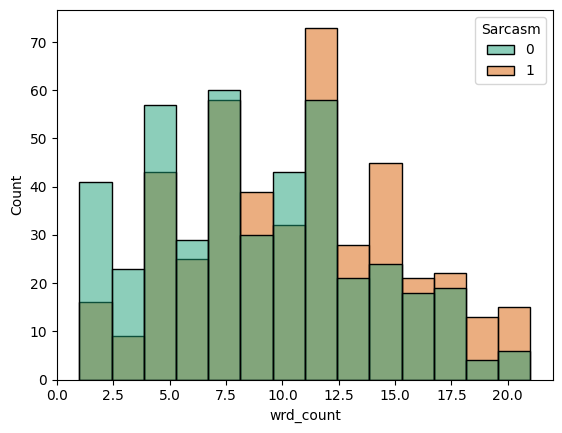

In [19]:
sns.histplot(data=plus, x="wrd_count", hue="Sarcasm", palette="Dark2")

<Axes: xlabel='SPEAKER', ylabel='count'>

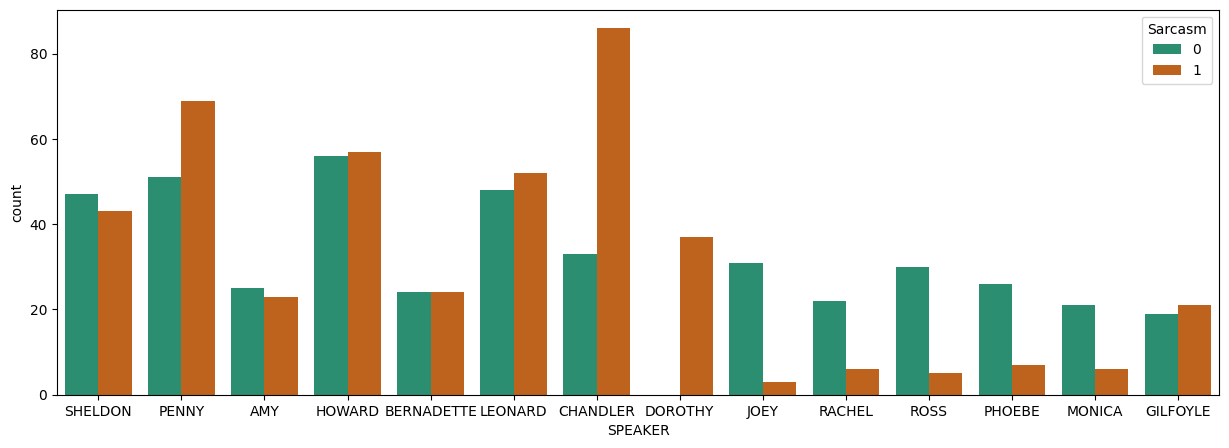

In [20]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="SPEAKER", hue="Sarcasm", palette="Dark2")

<Axes: xlabel='SPEAKER', ylabel='count'>

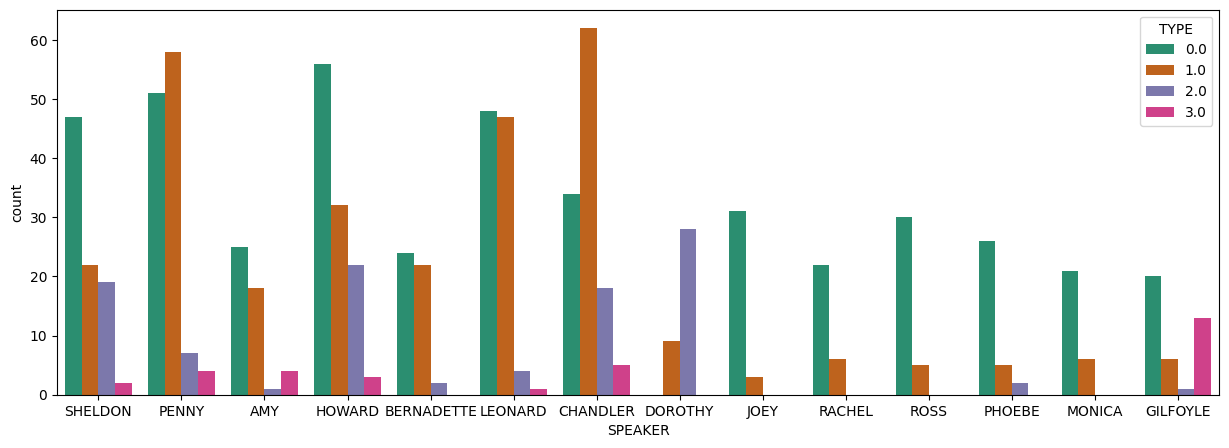

In [21]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="SPEAKER", hue="TYPE", palette="Dark2")

2026-01-26 22:09:07,540 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2026-01-26 22:09:07,552 - INFO     - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Axes: xlabel='TYPE', ylabel='count'>

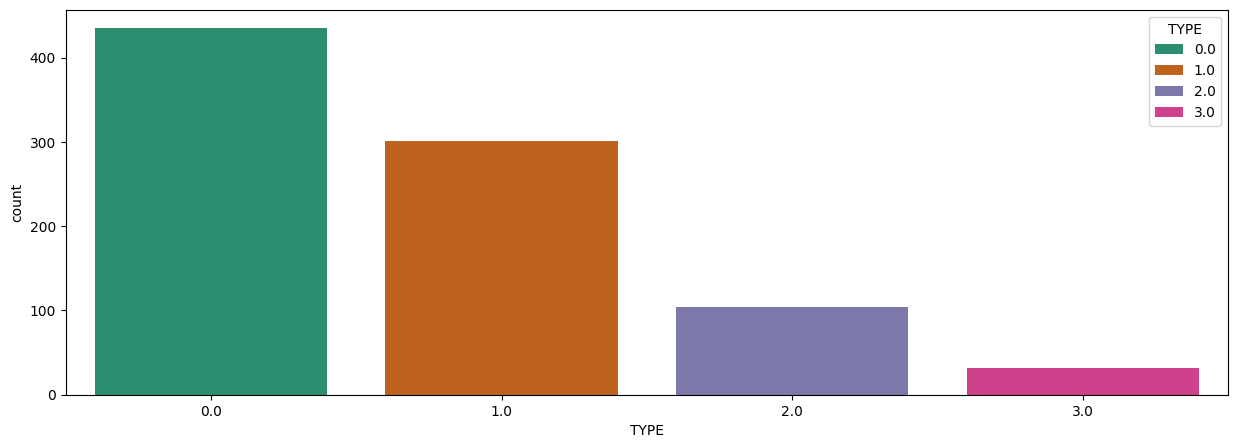

In [22]:
plt.figure(figsize=(15,5))
sns.countplot(data=plus, x="TYPE", hue = "TYPE",palette="Dark2")

In [49]:
aaa = plus.groupby("Sarcasm")["prom_1_intensity"].std().to_dict()
bbb = plus.groupby("Sarcasm")["prom_2_intensity"].std().to_dict()
ccc = plus.groupby("Sarcasm")["prom_3_intensity"].std().to_dict()
ddd = plus.groupby("Sarcasm")["prom_4_intensity"].std().to_dict()

In [50]:
dicts = [aaa,bbb,ccc,ddd]

sincere = [d[0] for d in dicts]   # class 0
sarcastic = [d[1] for d in dicts] # class 1

print(sincere)
print(sarcastic)


[1.1240326303062724, 0.39258517501900647, 0.23751250220284087, 0.14574286039536505]
[1.104054003486324, 0.42159241257206104, 0.23750002407266654, 0.16789018722002286]


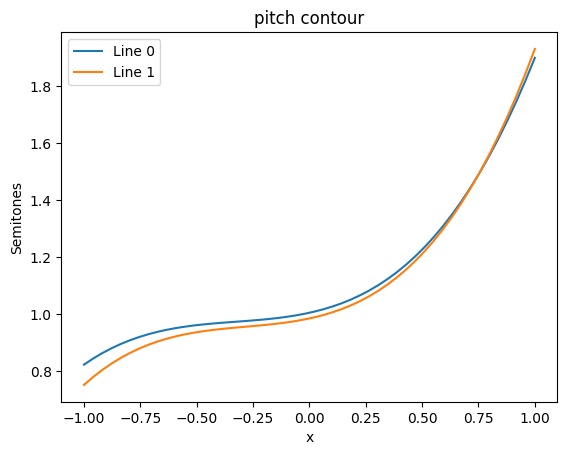

In [51]:
all_lists = [sincere, sarcastic]

X = np.linspace(-1, 1)

for i, polys in enumerate(all_lists):
    fff = dict(enumerate(polys))
    y = 0
    for m in range(0, 4):
        poly = eval_legendre(m, X) * fff[m]
        y += poly
    plt.plot(X, y, label=f"Line {i}")

plt.title("pitch contour")
plt.xlabel("x")
plt.ylabel("Semitones")
plt.legend()
plt.show()

In [45]:
aaa = plus.groupby("TYPE")["prom_1_intensity"].std().to_dict()
bbb = plus.groupby("TYPE")["prom_2_intensity"].std().to_dict()
ccc = plus.groupby("TYPE")["prom_3_intensity"].std().to_dict()
ddd = plus.groupby("TYPE")["prom_4_intensity"].std().to_dict()
print(aaa)

{0.0: 1.121782699761204, 1.0: 1.0869060085314217, 2.0: 1.1413346970428273, 3.0: 1.0808251878716975}


In [46]:
dicts = [aaa,bbb,ccc,ddd]

# Build 4 lists, one per index
list0 = [d[0] for d in dicts]
list1 = [d[1] for d in dicts]
list2 = [d[2] for d in dicts]
list3 = [d[3] for d in dicts]

print(list0)
print(list1)
print(list2)
print(list3)

[1.121782699761204, 0.39351837459570466, 0.2372365940959647, 0.1455806457180257]
[1.0869060085314217, 0.43281071981631314, 0.22498929187736985, 0.15798098993028864]
[1.1413346970428273, 0.3813117682262713, 0.260696222464705, 0.19755406224823038]
[1.0808251878716975, 0.4139289951849765, 0.28140244129791775, 0.1590968833092052]


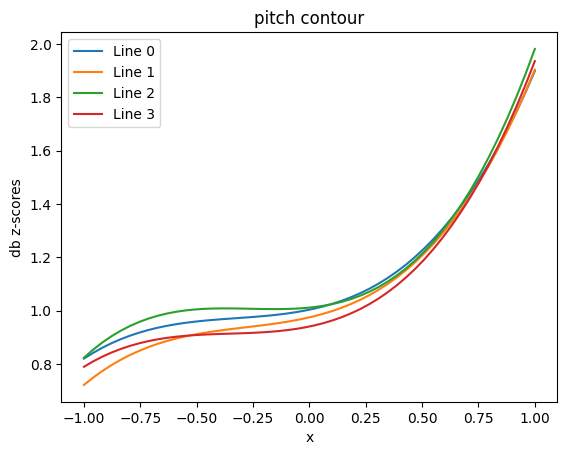

In [48]:
all_lists = [list0, list1, list2, list3]

X = np.linspace(-1, 1)

for i, polys in enumerate(all_lists):
    fff = dict(enumerate(polys))
    y = 0
    for m in range(0, 4):
        poly = eval_legendre(m, X) * fff[m]
        y += poly
    plt.plot(X, y, label=f"Line {i}")

plt.title("pitch contour")
plt.xlabel("x")
plt.ylabel("db z-scores")
plt.legend()
plt.show()